# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

If there are any questions, please contact ntu-ml-2021spring-ta@googlegroups.com

In [1]:
# !ps
# !kill 60

## GPU & RAM



In [1]:
# check if using a good GPU(P100 or V100)
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Select the Runtime > 'Change runtime type' menu to enable a GPU accelerator, ")
  print("and then re-execute this cell.")
else:
  print(gpu_info)

# check if using high-RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print("Your runtime has {:.1f} gigabytes of available RAM\n".format(ram_gb))

if ram_gb < 20:
  print("To enable a high-RAM runtime, select the Runtime > 'Change runtime type'")
  print("menu, and then select High-RAM in the Runtime shape dropdown. Then, ")
  print("re-execute this cell.")
else:
  print("You are using a high-RAM runtime!")

Fri May 28 22:45:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

## Config

In [2]:
WORKSPACE = '/content/gdrive/MyDrive/ColabNotebooks/HW11'
MODEL_NAME = 'base'
SAVING_PATH = f'{WORKSPACE}/checkpoint_{MODEL_NAME}.bin'
NUM_EPOCH = 2000
BATCH_SIZE = 512

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://drive.google.com/open?id=12-07DSquGdzN3JBHBChN4nMo3i8BqTiL). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !unzip {WORKSPACE}/real_or_drawing.zip

Mounted at /content/gdrive


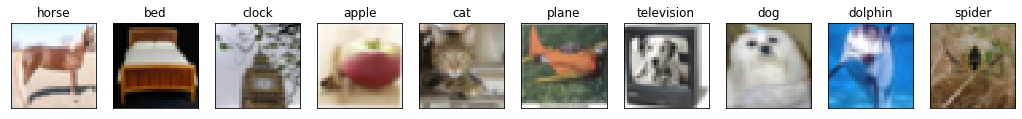

In [6]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

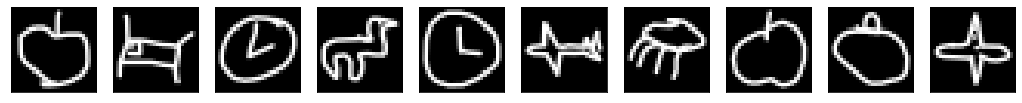

In [7]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

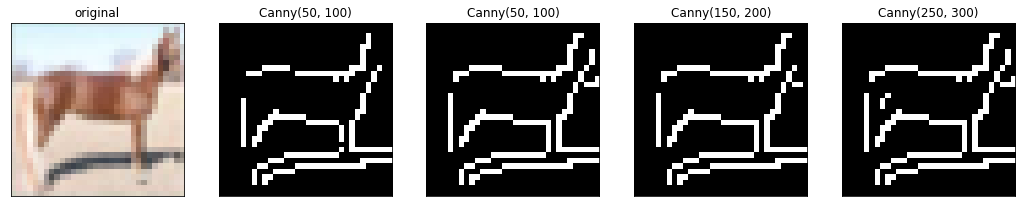

In [8]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
canny_50100 = cv2.Canny(gray_img, 400, 400)
plt.subplot(1, 5, 2)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 300, 400)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 350, 400)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 300, 350)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')


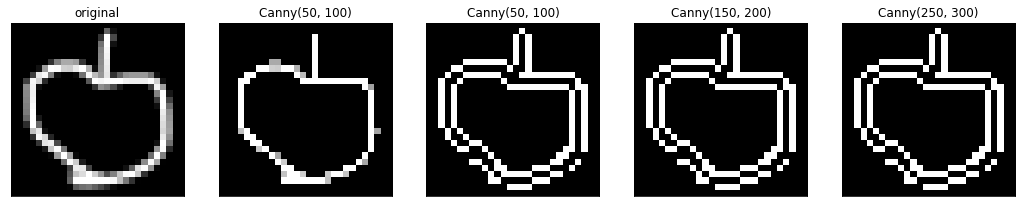

In [9]:
import numpy as np
from PIL import Image
import random

# def clean_img(img):
#     img = np.array(img)
#     threshold = random.randint(160, 180)
#     img[img>=threshold] = 255
#     img[img<threshold] = 0
#     img = Image.fromarray(img)
#     return img

def clean_img(img):
    img = np.array(img)
    threshold = random.randint(170, 255)
    img[img>=threshold] = 255
    threshold = random.randint(0, 170)
    img[img<threshold] = 0
    img = Image.fromarray(img)
    return img

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/test_data/0/00000.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
gray_img = clean_img(gray_img)
gray_img = np.array(gray_img)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='Canny(50, 100)', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 300, 400)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 350, 400)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 300, 350)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')


# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
 
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

get_rand_num = lambda x: np.random.randint(x)
get_rand_padding = lambda : (get_rand_num(2), get_rand_num(2), get_rand_num(2), get_rand_num(2))

source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), random.randint(150, 200), random.randint(280, 320))),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    transforms.Pad(get_rand_padding(), fill=0, padding_mode="constant"),
    transforms.Resize((32, 32)),
    transforms.Lambda(clean_img),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_dataset = ImageFolder(f'real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder(f'real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False)
pseudo_dataloader = [(None, None)]

2


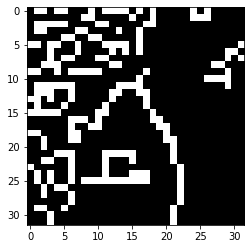

2


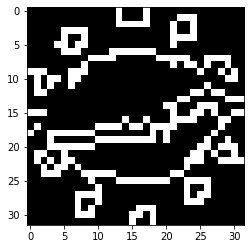

2


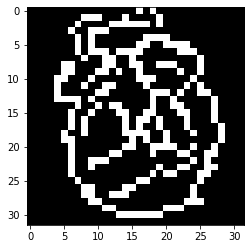

2


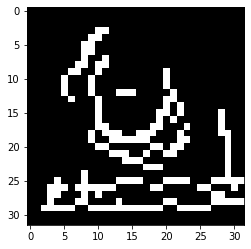

2


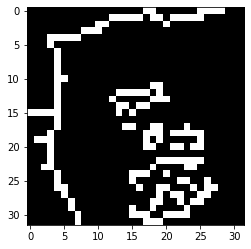

2


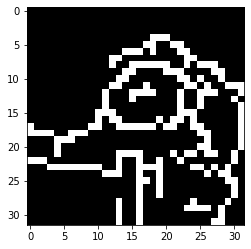

2


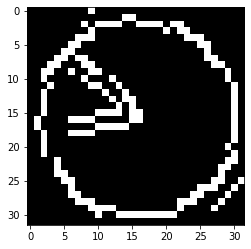

2


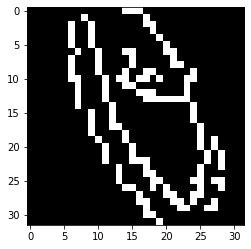

2


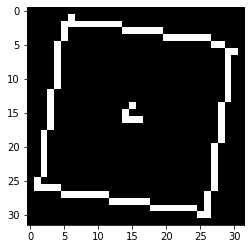

2


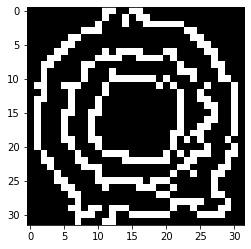

2


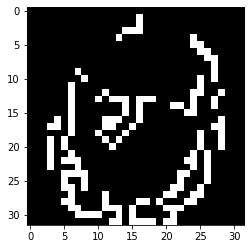

2


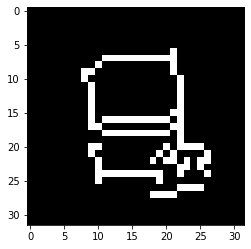

2


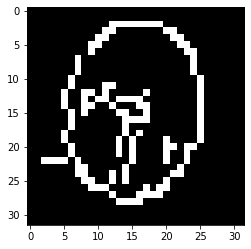

2


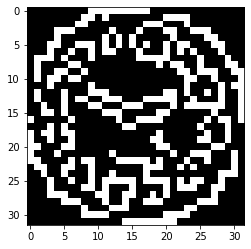

2


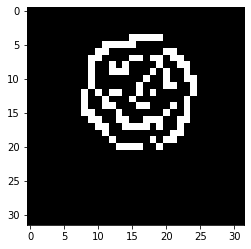

2


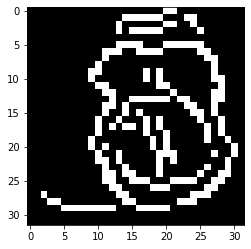

2


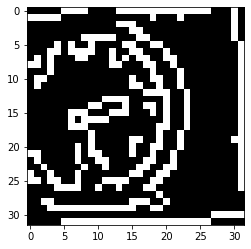

2


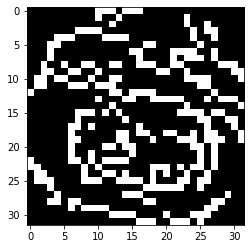

2


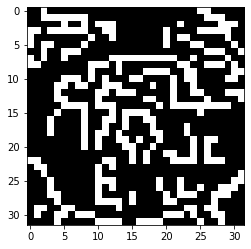

2


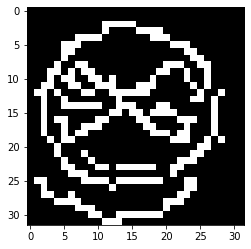

2


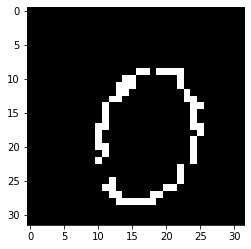

2


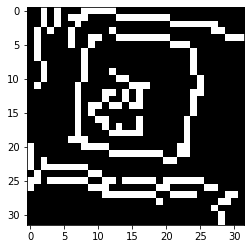

2


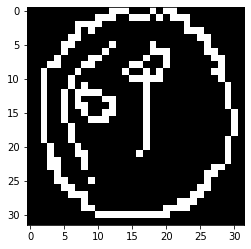

2


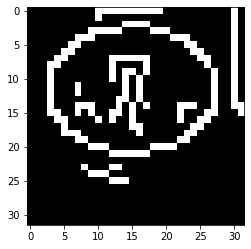

2


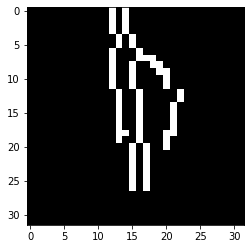

2


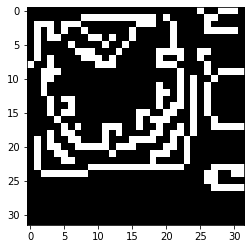

2


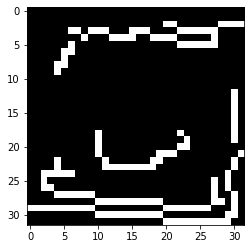

2


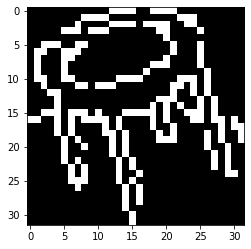

2


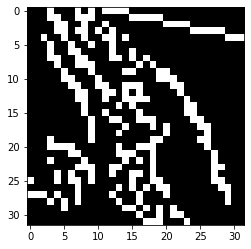

2


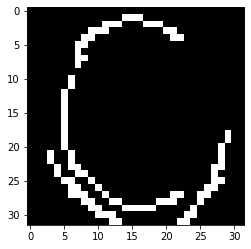

2


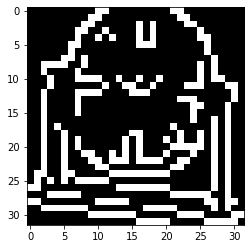

2


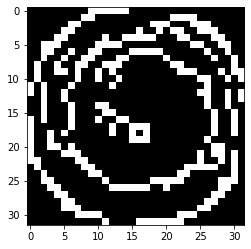

2


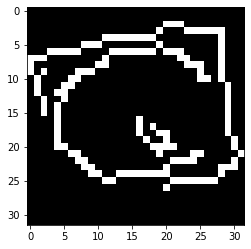

2


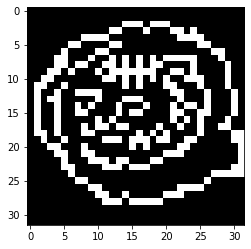

2


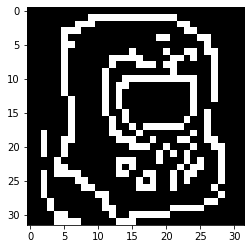

2


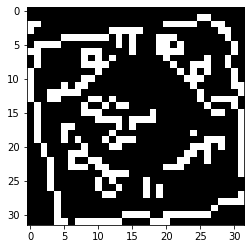

2


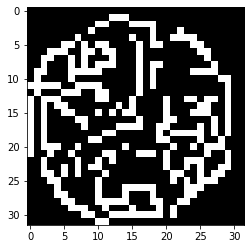

2


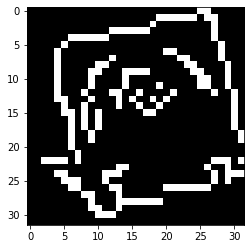

2


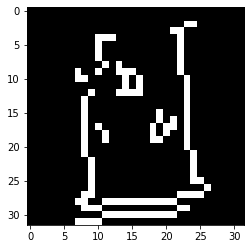

2


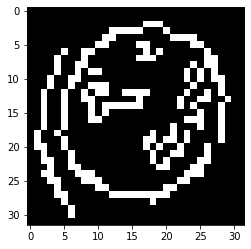

2


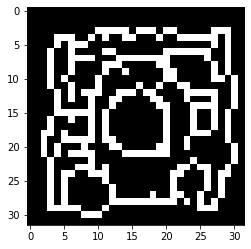

2


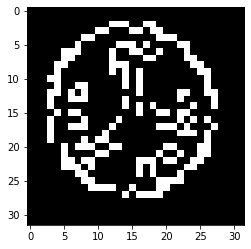

2


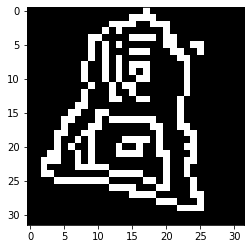

2


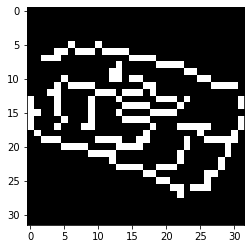

2


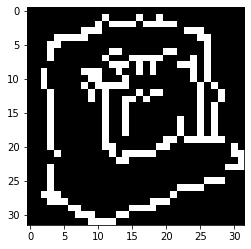

2


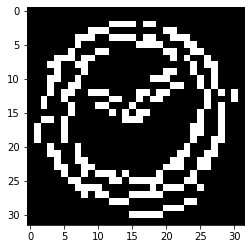

2


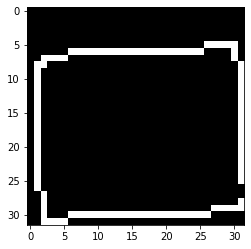

2


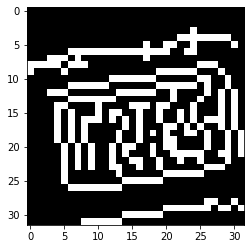

2


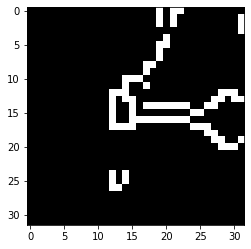

2


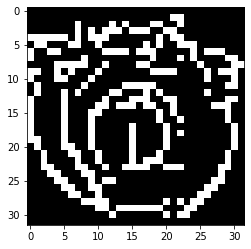

In [11]:
tensor_to_PIL = transforms.ToPILImage()

for i in range(1000, 1050):
    x = source_dataset[i][0]
    img = tensor_to_PIL(x).convert('RGB')
    print(source_dataset[i][1])
    plt.imshow(np.asarray(img))
    plt.show()


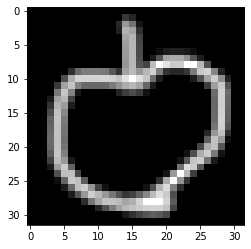

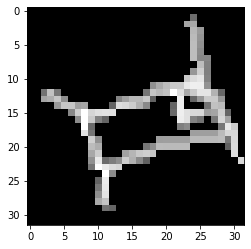

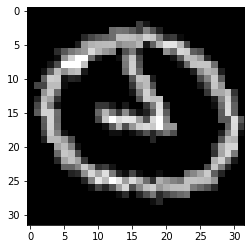

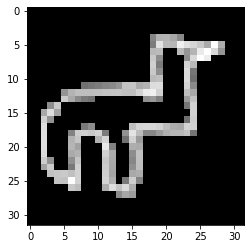

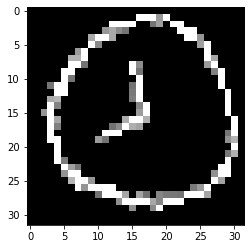

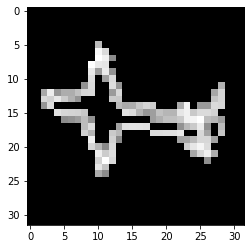

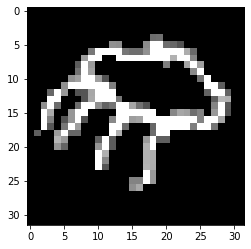

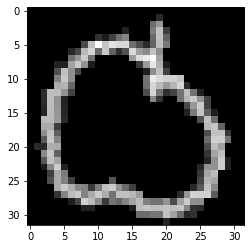

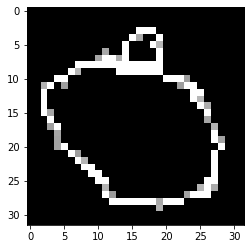

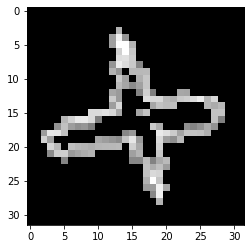

In [12]:
for i in range(10):
    x = target_dataset[i][0]
    img = tensor_to_PIL(x).convert('RGB')
    plt.imshow(np.asarray(img))
    plt.show()


# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [13]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(conv_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, 1, 1),         
            nn.LeakyReLU(),
            nn.BatchNorm2d(in_channels),

            nn.Conv2d(in_channels, out_channels, 3, 1, 1),        
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.block(x)

class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            # 32x32x1
            conv_block(1, 16),
            # 32x32x16
            conv_block(16, 32),
            nn.MaxPool2d(2, 2, 0),
            # 16x16x32
            conv_block(32, 64),
            nn.MaxPool2d(2, 2, 0),
            # 8x8x64
            conv_block(64, 128),
            nn.MaxPool2d(2, 2, 0),
            # 4x4x128
            conv_block(128, 256),
            nn.MaxPool2d(2, 2, 0),
            # 2x2x256
            conv_block(256, 512),
            nn.MaxPool2d(2, 2, 0),
            # 1x1x512
        )

    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c


# Pre-processing

Here we use Adam as our optimizor.

In [24]:
from os import path

model_f = FeatureExtractor().cuda()
model_c0 = LabelPredictor().cuda()
model_c1 = LabelPredictor().cuda()
# model_d = DomainClassifier().cuda()

# domain_weights = [len(target_dataset), len(source_dataset)]
# domain_weights_tensor = torch.FloatTensor(domain_weights).cuda()

# pseudo_cnt_labels = [10000] * 10
class_criterion = nn.CrossEntropyLoss()
# diff_criterion = nn.L1Loss()
# domain_criterion = nn.CrossEntropyLoss(weight=domain_weights_tensor)

optim_f = optim.AdamW(model_f.parameters())
optim_c0 = optim.AdamW(model_c0.parameters())
optim_c1 = optim.AdamW(model_c1.parameters())
# optim_d = optim.AdamW(model_d.parameters())

epoch_prev = -1

# load state if saved
if path.exists(SAVING_PATH):
    checkpoint = torch.load(SAVING_PATH+'_mcd')
    model_f.load_state_dict(checkpoint["model_f"])
    model_c0.load_state_dict(checkpoint["model_c0"])
    model_c1.load_state_dict(checkpoint["model_c1"])
    # model_d.load_state_dict(checkpoint["model_d"])
    optim_f.load_state_dict(checkpoint["optim_f"])
    optim_c0.load_state_dict(checkpoint["optim_c0"])
    optim_c1.load_state_dict(checkpoint["optim_c1"])
    # optim_d.load_state_dict(checkpoint["optim_d"])
    epoch_prev = checkpoint["epoch"]

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [33]:
from itertools import cycle

get_avg = lambda x, y: x / y if y != 0 else -1
softmax = nn.Softmax(dim=1)

def train_epoch(source_dataloader, target_dataloader, pseudo_dataloader):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    c0_loss_tot, c1_loss_tot = 0.0, 0.0
    c0_hit_tot, c1_hit_tot = 0.0, 0.0
    diff_loss_tot = 0.0
    domain_loss_tot = 0.0
    d_hit_tot = 0.0
    src_num = 0
    tgt_num = 0
    pseudo_hit, pseudo_num = 0.0, 0.0

    if len(pseudo_dataloader) == 0:
        pseudo_dataloader = [(None, None)]

    model_f.train()
    model_c0.train()
    model_c1.train()
    # model_d.train()

    for i, ((source_data, source_label), (target_data, _), (pseudo_data, pseudo_label)) in enumerate(zip(cycle(source_dataloader), target_dataloader, cycle(pseudo_dataloader))):
        if len(pseudo_dataloader) * BATCH_SIZE < 30000:
            src_num += len(source_data)
            tgt_num += len(target_data)

            source_data = source_data.cuda()
            source_label = source_label.cuda()
            target_data = target_data.cuda()

            # step1: train 2 models
            optim_f.zero_grad()
            optim_c0.zero_grad()
            optim_c1.zero_grad()

            src_feat = model_f(source_data)
            src_c0_logit = model_c0(src_feat)
            src_c1_logit = model_c1(src_feat)

            c0_loss = class_criterion(src_c0_logit, source_label)
            c0_loss_tot += c0_loss.item()
            c0_hit_tot += torch.sum(torch.argmax(src_c0_logit, dim=1) == source_label).item()

            c1_loss = class_criterion(src_c1_logit, source_label)
            c1_loss_tot += c1_loss.item()
            c1_hit_tot += torch.sum(torch.argmax(src_c1_logit, dim=1) == source_label).item()

            loss = c0_loss + c1_loss
            loss.backward()

            optim_f.step()
            optim_c0.step()
            optim_c1.step()

            # step2: fix model_f, train class_c0/1 to maximize discrepancy, but also minimize src_loss
            optim_f.zero_grad()
            optim_c0.zero_grad()
            optim_c1.zero_grad()

            src_feat = model_f(source_data)
            src_c0_logit = model_c0(src_feat)
            src_c1_logit = model_c1(src_feat)

            tgt_feat = model_f(target_data)
            tgt_c0_logit = model_c0(tgt_feat.detach())
            tgt_c1_logit = model_c1(tgt_feat.detach())

            loss = class_criterion(src_c0_logit, source_label)
            loss += class_criterion(src_c1_logit, source_label)
            loss += -torch.mean(torch.abs(softmax(tgt_c0_logit) - softmax(tgt_c1_logit)))

            loss.backward()

            optim_c0.step()
            optim_c1.step()

            # step3: fix modelc0/1, train model_f to minimize discrepancy
            for _ in range(4):
                optim_f.zero_grad()
                optim_c0.zero_grad()
                optim_c1.zero_grad()

                tgt_feat = model_f(target_data)
                tgt_c0_logit = model_c0(tgt_feat)
                tgt_c1_logit = model_c1(tgt_feat)

                loss = torch.mean(torch.abs(softmax(tgt_c0_logit) - softmax(tgt_c1_logit)))
                diff_loss_tot += loss.item()
                loss.backward()

                optim_f.step() 

        # train on pseudo label
        if pseudo_data is not None:
            pseudo_data, pseudo_label = pseudo_data.cuda(), pseudo_label.cuda()

            optim_f.zero_grad()
            optim_c0.zero_grad()
            optim_c1.zero_grad()

            feat = model_f(pseudo_data)
            class_logits_0 = model_c0(feat)
            class_logits_1 = model_c1(feat)

            loss0 = class_criterion(class_logits_0, pseudo_label)
            loss1 = class_criterion(class_logits_1, pseudo_label)
            loss = loss0 + loss1
            loss.backward()

            optim_f.step()
            optim_c0.step()
            optim_c1.step()

            pseudo_hit += torch.sum(torch.argmax(class_logits_0, dim=1) == pseudo_label).item()
            pseudo_hit += torch.sum(torch.argmax(class_logits_1, dim=1) == pseudo_label).item()
            pseudo_num += 2 * pseudo_data.shape[0]

        # # train discriminator
        # src_label = torch.ones([source_data.shape[0]], dtype=torch.int64).cuda()
        # tgt_label = torch.zeros([target_data.shape[0]], dtype=torch.int64).cuda()
        
        # src_feat = model_f(source_data)
        # tgt_feat = model_f(target_data)

        # src_d_logits = model_d(src_feat.detach())
        # tgt_d_logits = model_d(tgt_feat.detach())

        # loss = domain_criterion(src_d_logits, src_label)
        # loss += domain_criterion(tgt_d_logits, tgt_label)
        # domain_loss_tot += loss.item()

        # loss.backward()
        # optim_d.step()

        # optim_d.zero_grad()

        # # train on feature extractor
        # src_d_logits = model_d(src_feat)
        # tgt_d_logits = model_d(tgt_feat)

        # loss = -domain_criterion(src_d_logits, src_label)
        # loss += -domain_criterion(tgt_d_logits, tgt_label)

        # loss.backward()
        # optim_f.step()

        # optim_f.zero_grad()

        # # acc of domain classifier
        # d_hit_tot += torch.sum(torch.argmax(src_d_logits, dim=1) == src_label).item()
        # d_hit_tot += torch.sum(torch.argmax(tgt_d_logits, dim=1) == tgt_label).item()

    c0_loss = get_avg(c0_loss_tot, src_num)
    c1_loss = get_avg(c1_loss_tot, src_num)
    c0_acc = get_avg(c0_hit_tot, src_num)
    c1_acc = get_avg(c1_hit_tot, src_num)
    diff_loss = get_avg(diff_loss_tot, tgt_num) / 4
    d_acc = get_avg(d_hit_tot, src_num+tgt_num)
    domain_loss = get_avg(domain_loss_tot, src_num+tgt_num)
    pseudo_acc = get_avg(pseudo_hit, pseudo_num)

    return c0_loss, c1_loss, c0_acc, c1_acc, diff_loss, d_acc, domain_loss, pseudo_acc

def set_pseudo_label(target_dataset, threshold):
    target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False)
    good_labels, good_idxs = None, None
    i_abs = 0
    model_f.eval()
    model_c0.eval()
    model_c1.eval()
    for i, (target_data, _) in enumerate(target_dataloader):
        target_data = target_data.cuda()
        target_feat = model_f(target_data)

        target_logits_c0 = model_c0(target_feat)
        target_logits_c1 = model_c1(target_feat)
        # target_logits_c1 = target_logits_c0

        probs_c0 = softmax(target_logits_c0)
        probs_c1 = softmax(target_logits_c1)

        probs_c0, labels_c0 = torch.max(probs_c0, 1)
        probs_c1, labels_c1 = torch.max(probs_c1, 1)

        is_good_idxs = (labels_c0 == labels_c0)
        is_good_idxs = torch.logical_and(is_good_idxs, (probs_c0 > threshold))
        is_good_idxs = torch.logical_and(is_good_idxs, (probs_c1 > threshold))
        good_labels_tmp = labels_c0[is_good_idxs].cpu().numpy()
        good_idxs_tmp = is_good_idxs.nonzero(as_tuple=True)[0].cpu().numpy() + i_abs
        if good_labels is None:
            good_labels = good_labels_tmp
            good_idxs = good_idxs_tmp

        else:
            good_labels = np.concatenate((good_labels, good_labels_tmp), axis=0)
            good_idxs = np.concatenate((good_idxs, good_idxs_tmp), axis=0)

        i_abs += len(target_data)

    if good_labels is None:
        return None

    cnt_labels = [0] * 10
    for good_label in good_labels:
        cnt_labels[good_label] += 1

    print(cnt_labels)

    good_lists = []
    for i in range(len(good_labels)):
        good_lists.append([good_labels[i], good_idxs[i]])

    random.shuffle(good_lists)

    cnt_per_label = min(cnt_labels)
    cnt_pseudo = [cnt_per_label] * 10
    pseudo_idxs = []
    for i in range(len(good_lists)):
        label, idx = good_lists[i]
        if cnt_pseudo[label] == 0:
            continue

        cnt_pseudo[label] -= 1
        target_dataset.samples[idx] = (target_dataset.samples[idx][0], label)
        pseudo_idxs.append(idx)

    pseudo_dataset = torch.utils.data.Subset(target_dataset, pseudo_idxs)
    pseudo_dataloader = DataLoader(pseudo_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f'length of psedo_dataset: {len(pseudo_dataset)}')

    return pseudo_dataloader

if epoch_prev > 10:
    pseudo_dataloader = set_pseudo_label(target_dataset, 0.99)

for epoch in range(epoch_prev+1, NUM_EPOCH):
    c0_loss, c1_loss, c0_acc, c1_acc, diff_loss, d_acc, domain_loss, pseudo_acc = train_epoch(source_dataloader, target_dataloader, pseudo_dataloader)

    checkpoint = {
        "model_f": model_f.state_dict(),
        "model_c0": model_c0.state_dict(),
        "model_c1": model_c1.state_dict(),            
        # "model_d": model_d.state_dict(),            
        "optim_f": optim_f.state_dict(),
        "optim_c0": optim_c0.state_dict(),
        "optim_c1": optim_c1.state_dict(),
        # "optim_d": optim_d.state_dict(),
        "epoch": epoch,
    }

    torch.save(checkpoint, SAVING_PATH+'_mcd')

    print('epoch {:>3d}: c0_loss: {:6.6f}, c1_loss: {:6.6f}, c0_acc: {:6.4f}, c1_acc: {:6.4f}, diff_loss: {:6.6f}, d_acc: {:6.4f}, domain_loss: {:6.6f}, pseudo_acc: {:6.4f}'.format(epoch, c0_loss, c1_loss, c0_acc, c1_acc, diff_loss, d_acc, domain_loss, pseudo_acc))
    if epoch > 10:
        pseudo_dataloader = set_pseudo_label(target_dataset, 0.99)


[11360, 9759, 9933, 9897, 7801, 10950, 9521, 4725, 10392, 8738]
length of psedo_dataset: 47250
epoch  33: c0_loss: 0.000528, c1_loss: 0.000534, c0_acc: 0.9258, c1_acc: 0.9256, diff_loss: 0.000006, d_acc: 0.0000, domain_loss: 0.000000, pseudo_acc: 0.9884
[11708, 9990, 9782, 9958, 8166, 10886, 9672, 5200, 10512, 9159]
length of psedo_dataset: 52000
epoch  34: c0_loss: 0.000271, c1_loss: 0.000271, c0_acc: 0.9632, c1_acc: 0.9637, diff_loss: 0.000004, d_acc: 0.0000, domain_loss: 0.000000, pseudo_acc: 0.9872
[10195, 10162, 9520, 9977, 8142, 10073, 9520, 4976, 10704, 9225]
length of psedo_dataset: 49760
epoch  35: c0_loss: 0.000221, c1_loss: 0.000222, c0_acc: 0.9707, c1_acc: 0.9707, diff_loss: 0.000005, d_acc: 0.0000, domain_loss: 0.000000, pseudo_acc: 0.9902
[10194, 9885, 9735, 9955, 8232, 10299, 9557, 5239, 10060, 9436]
length of psedo_dataset: 52390
epoch  36: c0_loss: 0.000204, c1_loss: 0.000205, c0_acc: 0.9727, c1_acc: 0.9725, diff_loss: 0.000005, d_acc: 0.0000, domain_loss: 0.000000, ps

KeyboardInterrupt: ignored

In [ ]:
tensor_to_PIL = transforms.ToPILImage()

# from matplotlib.pyplot import imshow
for xs, ys in pseudo_dataloader:
    for x, y in zip(xs, ys):
        print(y)
        img = tensor_to_PIL(x).convert('RGB')
        plt.imshow(np.asarray(img))
        plt.show()


# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


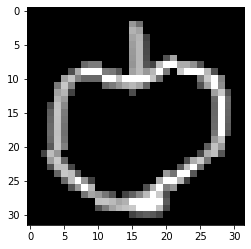

tensor(0.8743, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.8421, device='cuda:0', grad_fn=<SelectBackward>)
1


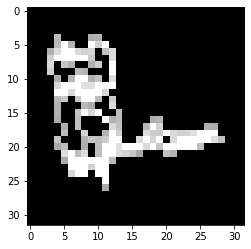

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


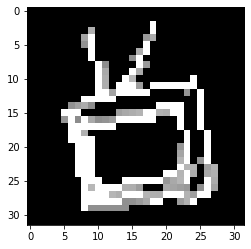

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
0


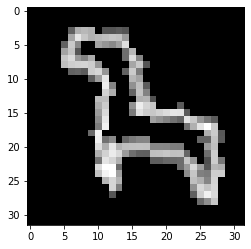

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
5


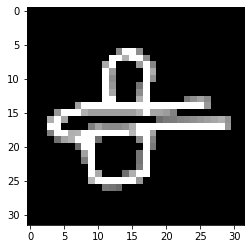

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


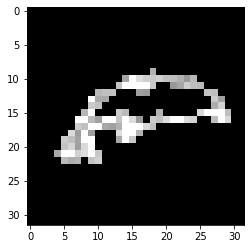

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
7


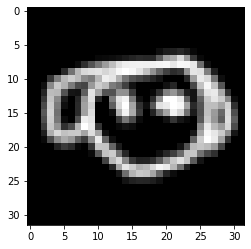

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


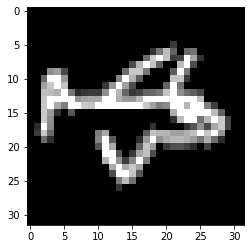

tensor(0.9981, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9980, device='cuda:0', grad_fn=<SelectBackward>)
5


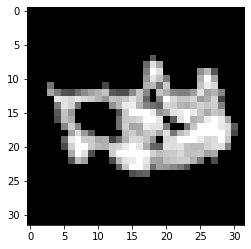

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
5


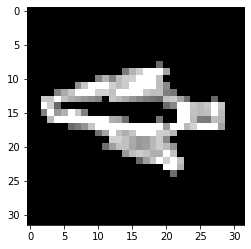

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


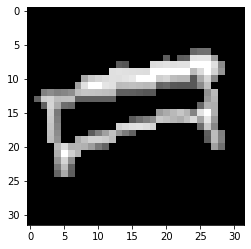

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


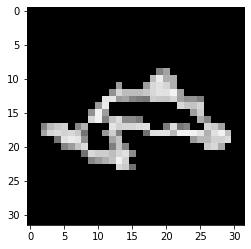

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


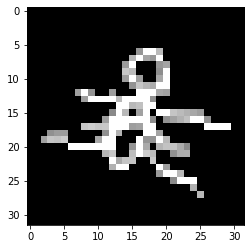

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


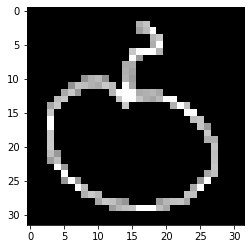

tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
0


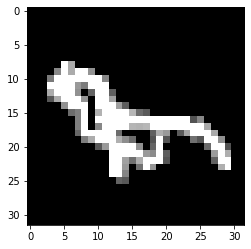

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


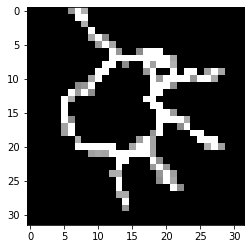

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


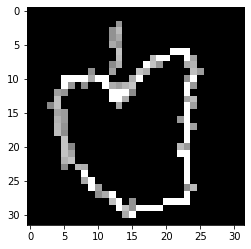

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


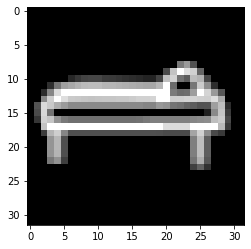

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


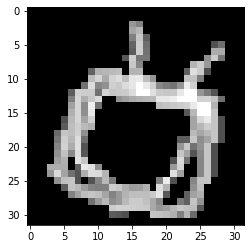

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


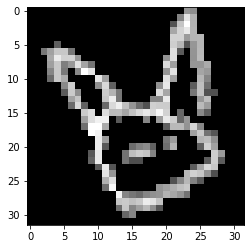

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


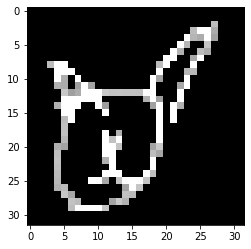

tensor(0.9832, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(0.9841, device='cuda:0', grad_fn=<SelectBackward>)
2


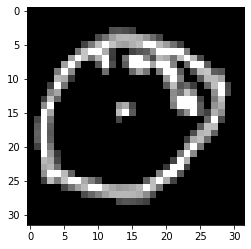

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


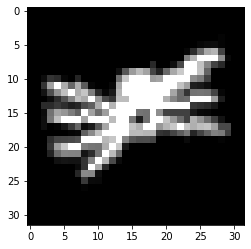

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


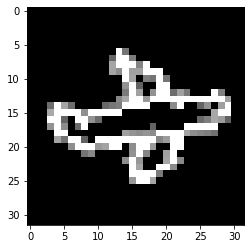

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
5


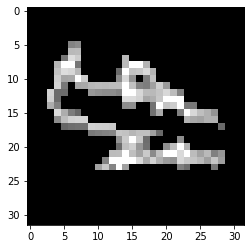

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


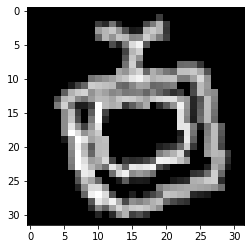

tensor(0.9978, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9986, device='cuda:0', grad_fn=<SelectBackward>)
9


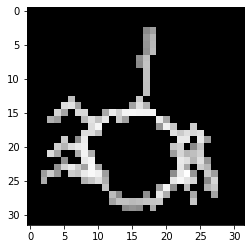

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


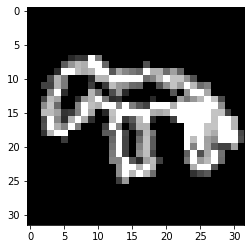

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


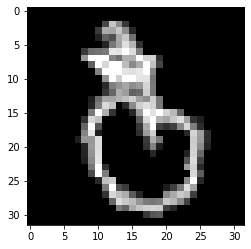

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


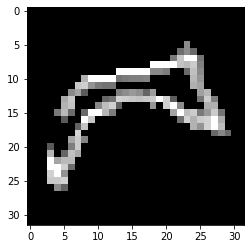

tensor(0.9955, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9958, device='cuda:0', grad_fn=<SelectBackward>)
7


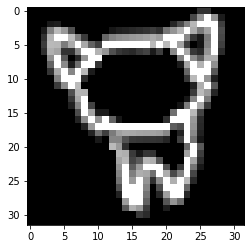

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


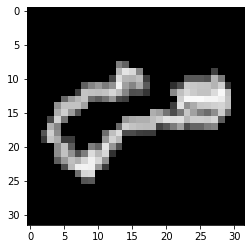

tensor(0.3857, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.4394, device='cuda:0', grad_fn=<SelectBackward>)
7


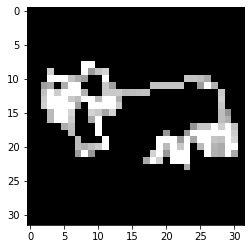

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
7


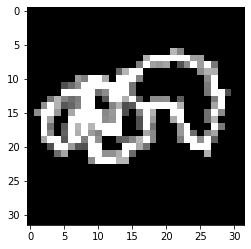

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


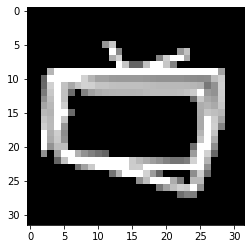

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


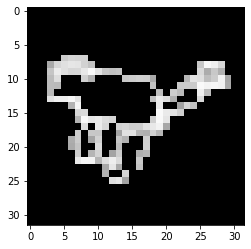

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7


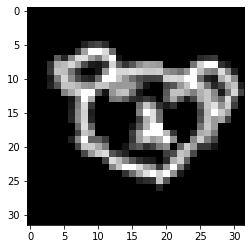

tensor(0.8394, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.8737, device='cuda:0', grad_fn=<SelectBackward>)
7


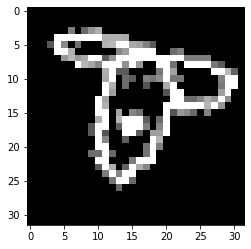

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


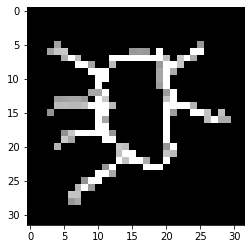

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


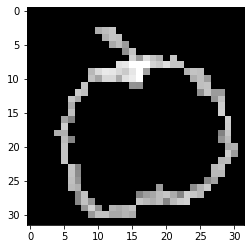

tensor(0.9872, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(0.9863, device='cuda:0', grad_fn=<SelectBackward>)
2


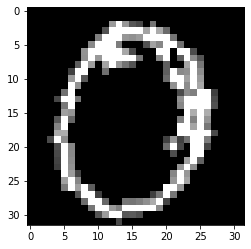

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


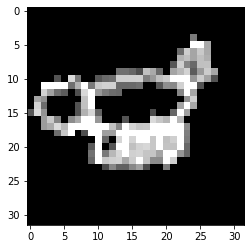

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


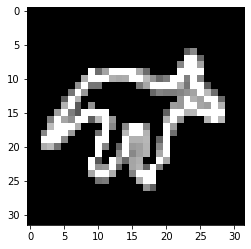

tensor(0.9969, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9968, device='cuda:0', grad_fn=<SelectBackward>)
7


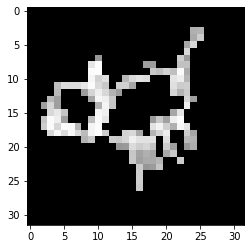

tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
6


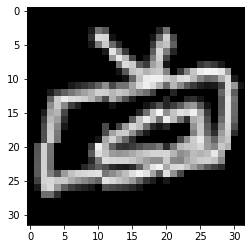

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


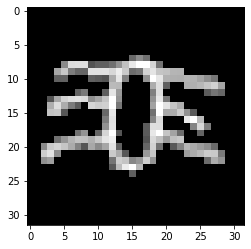

tensor(0.9304, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.8807, device='cuda:0', grad_fn=<SelectBackward>)
7


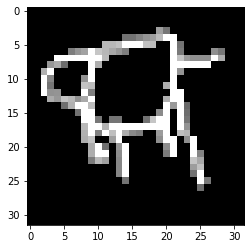

tensor(0.9960, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9951, device='cuda:0', grad_fn=<SelectBackward>)
4


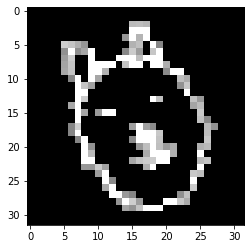

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


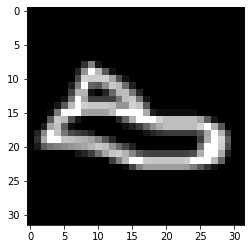

tensor(0.9874, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9915, device='cuda:0', grad_fn=<SelectBackward>)
7


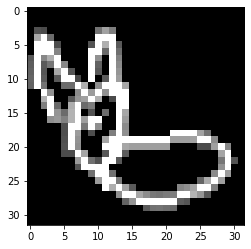

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


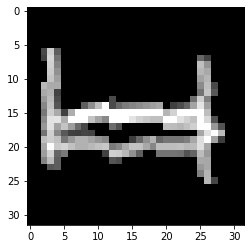

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


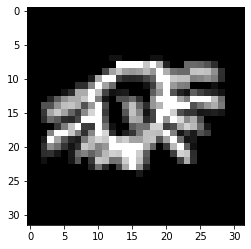

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


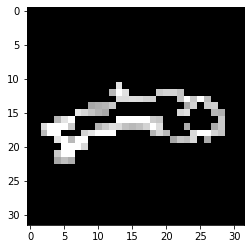

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


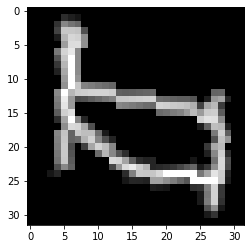

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


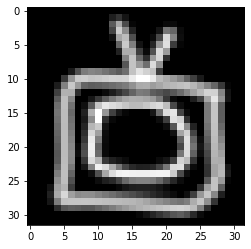

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


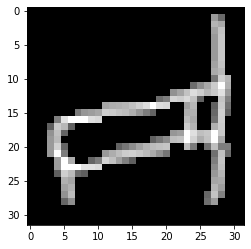

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


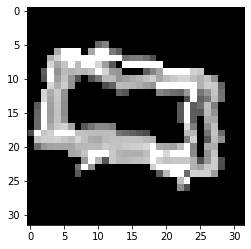

tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2


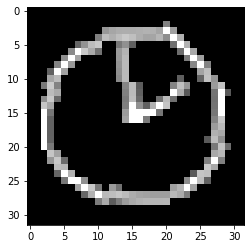

tensor(0.9992, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9991, device='cuda:0', grad_fn=<SelectBackward>)
9


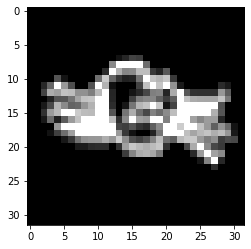

tensor(0.9962, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9968, device='cuda:0', grad_fn=<SelectBackward>)
8


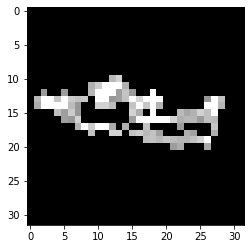

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


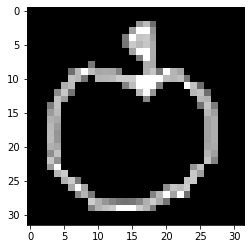

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


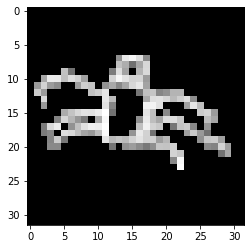

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


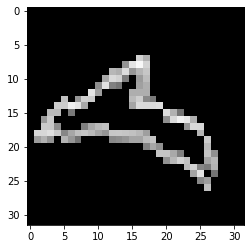

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
9


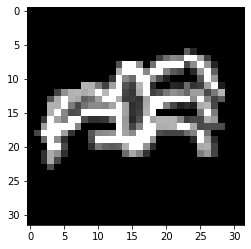

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


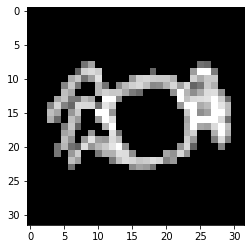

tensor(0.8576, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9073, device='cuda:0', grad_fn=<SelectBackward>)
0


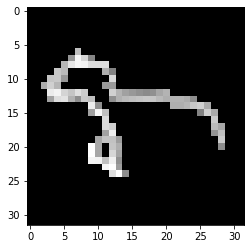

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


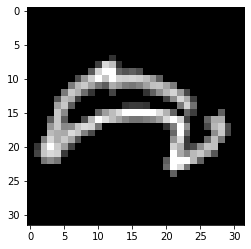

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


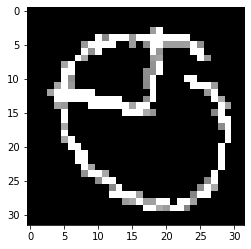

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


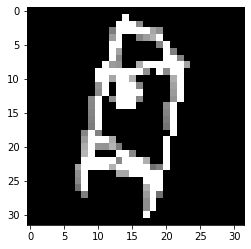

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


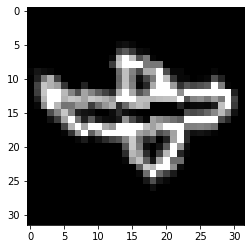

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


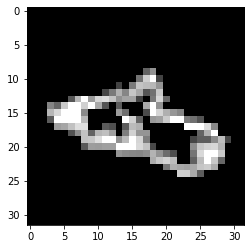

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
8


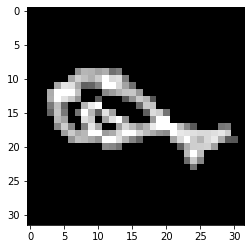

tensor(0.9135, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9019, device='cuda:0', grad_fn=<SelectBackward>)
1


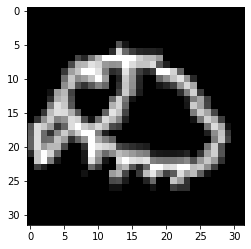

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
1


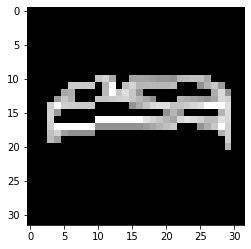

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
7


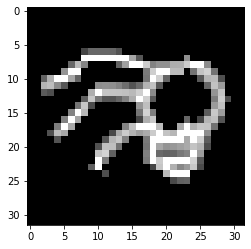

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


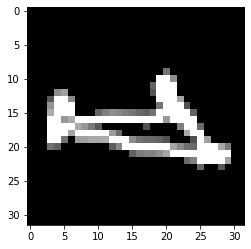

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


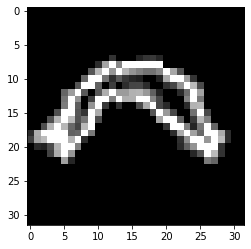

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


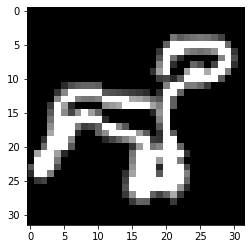

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


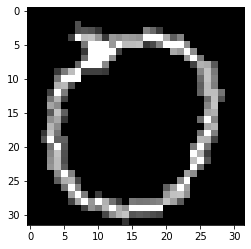

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


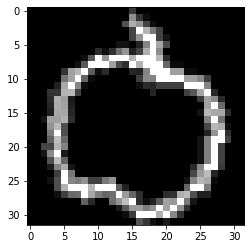

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
0


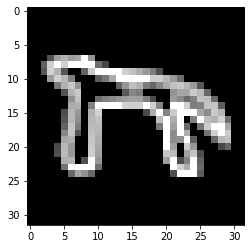

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


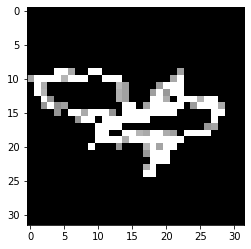

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


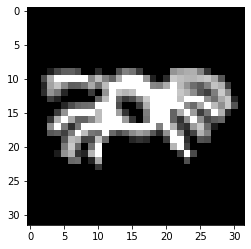

tensor(0.9676, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9724, device='cuda:0', grad_fn=<SelectBackward>)
0


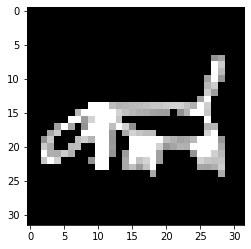

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


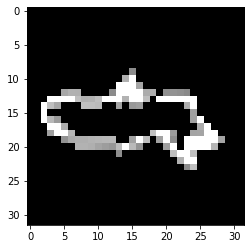

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


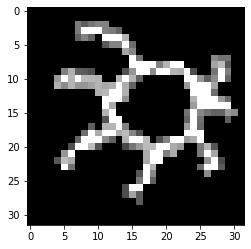

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


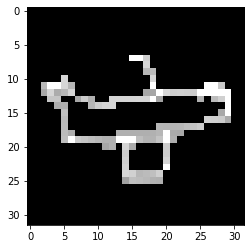

tensor(0.9974, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9970, device='cuda:0', grad_fn=<SelectBackward>)
4


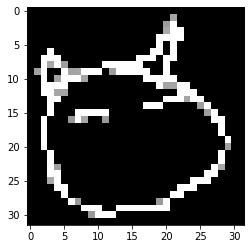

tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
7


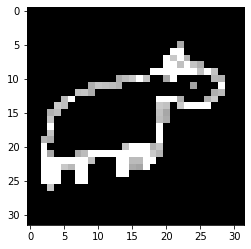

tensor(0.9986, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9988, device='cuda:0', grad_fn=<SelectBackward>)
7


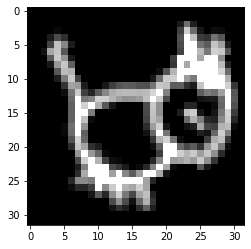

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


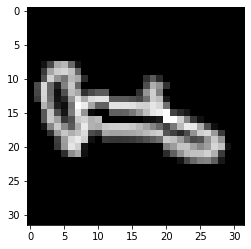

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


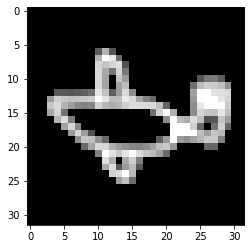

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


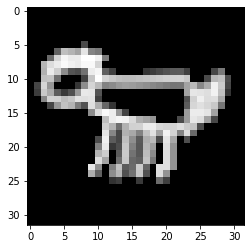

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


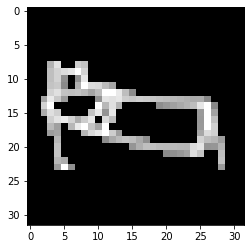

tensor(0.7225, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.7670, device='cuda:0', grad_fn=<SelectBackward>)
7


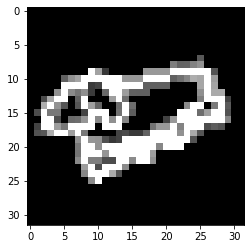

tensor(0.9978, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9972, device='cuda:0', grad_fn=<SelectBackward>)
4


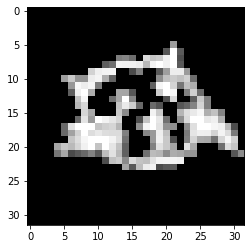

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


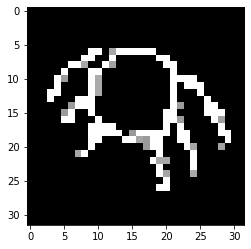

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


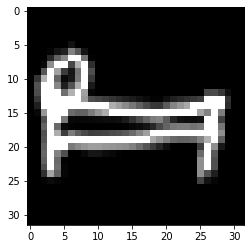

tensor(0.9882, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9926, device='cuda:0', grad_fn=<SelectBackward>)
9


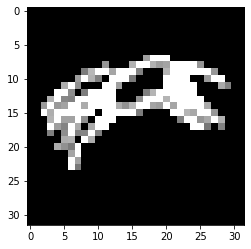

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


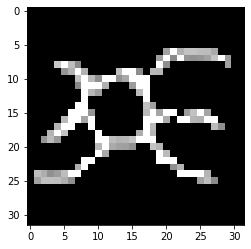

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
4


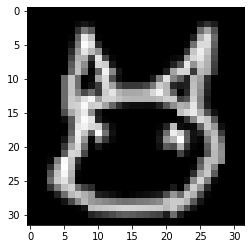

tensor(0.9824, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9641, device='cuda:0', grad_fn=<SelectBackward>)
1


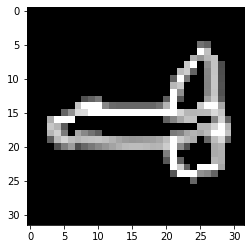

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
1


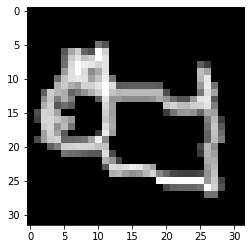

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9993, device='cuda:0', grad_fn=<SelectBackward>)
9


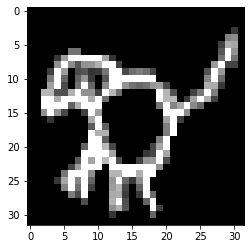

tensor(0.8200, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.8145, device='cuda:0', grad_fn=<SelectBackward>)
7


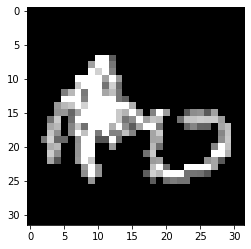

tensor(0.6819, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.7037, device='cuda:0', grad_fn=<SelectBackward>)
0


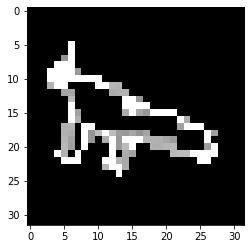

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


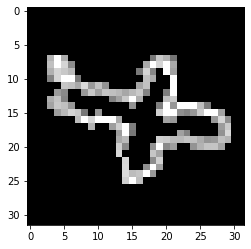

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


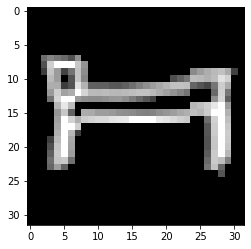

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


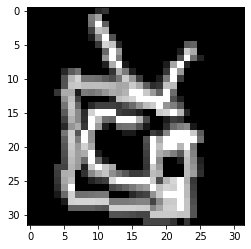

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


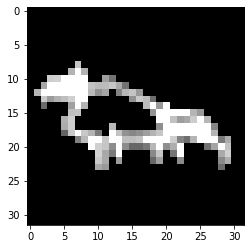

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


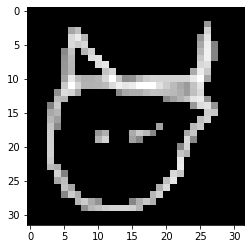

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


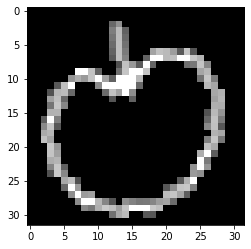

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


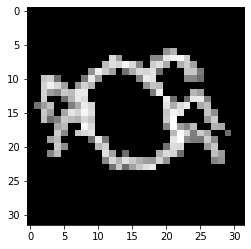

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


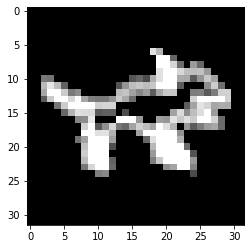

tensor(0.9607, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9727, device='cuda:0', grad_fn=<SelectBackward>)
9


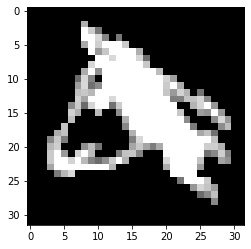

tensor(0.9988, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(0.9989, device='cuda:0', grad_fn=<SelectBackward>)
2


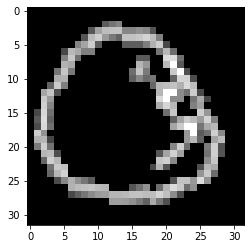

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


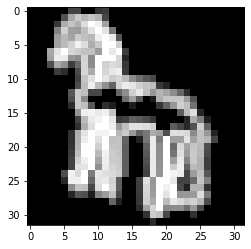

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


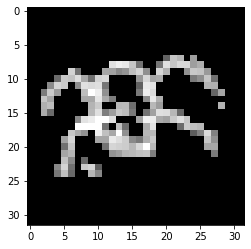

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


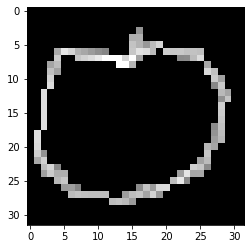

tensor(0.9992, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9992, device='cuda:0', grad_fn=<SelectBackward>)
8


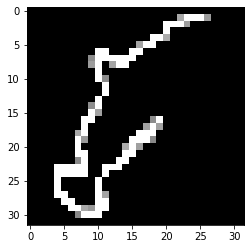

tensor(0.9835, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9851, device='cuda:0', grad_fn=<SelectBackward>)
5


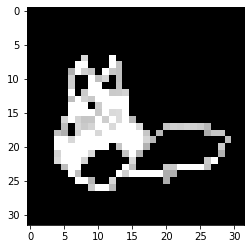

tensor(0.9988, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9989, device='cuda:0', grad_fn=<SelectBackward>)
0


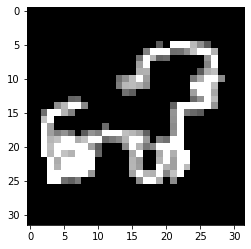

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


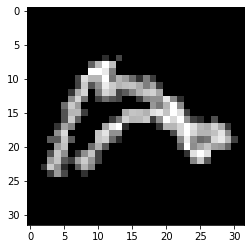

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


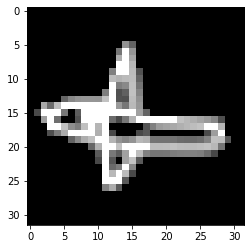

tensor(0.9993, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9989, device='cuda:0', grad_fn=<SelectBackward>)
8


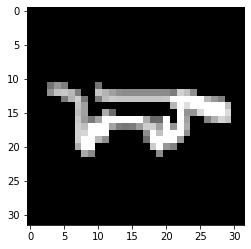

tensor(0.5342, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.6094, device='cuda:0', grad_fn=<SelectBackward>)
7


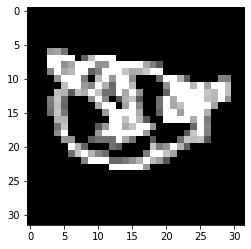

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


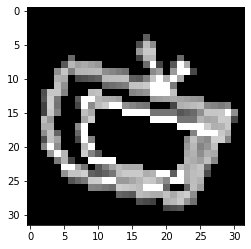

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


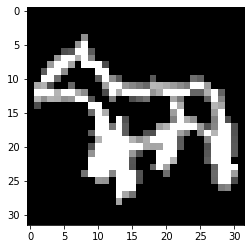

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


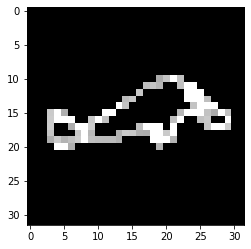

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
5


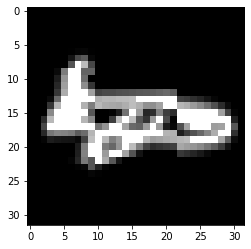

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


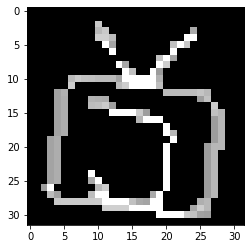

tensor(0.9226, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9454, device='cuda:0', grad_fn=<SelectBackward>)
9


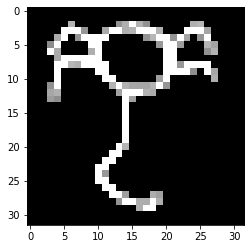

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


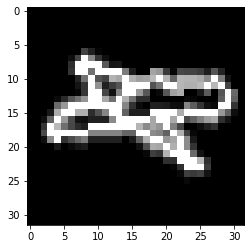

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


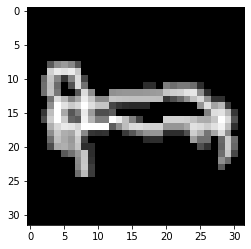

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


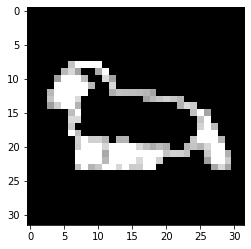

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


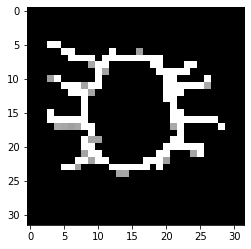

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
7


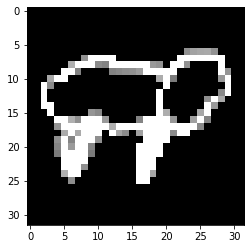

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


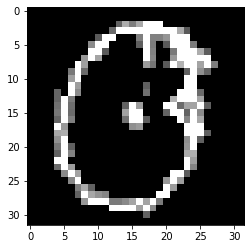

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


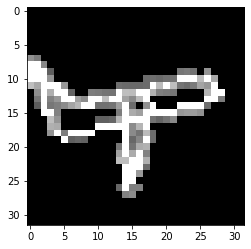

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
9


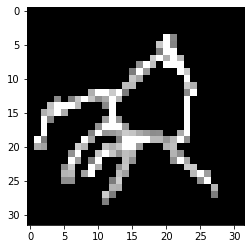

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


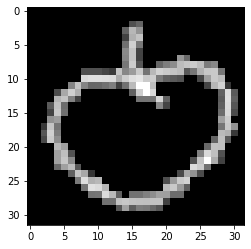

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7


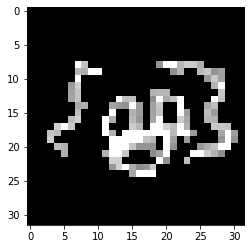

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


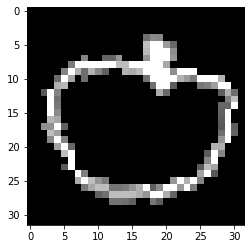

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


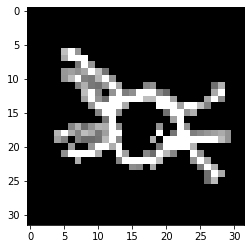

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


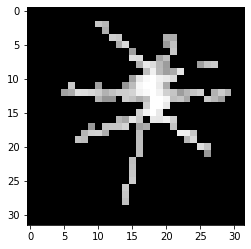

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


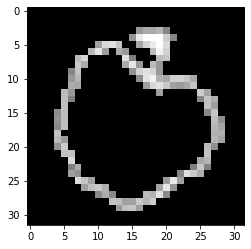

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


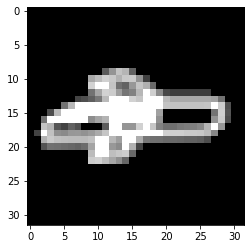

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


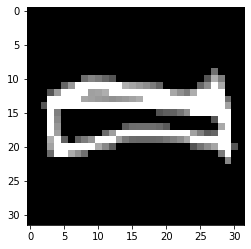

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4


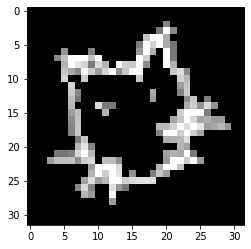

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


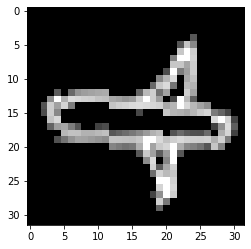

tensor(0.9958, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9949, device='cuda:0', grad_fn=<SelectBackward>)
0


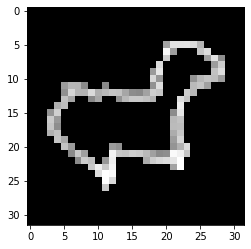

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


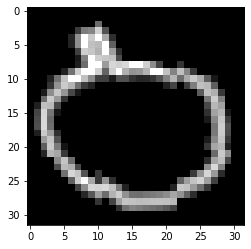

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


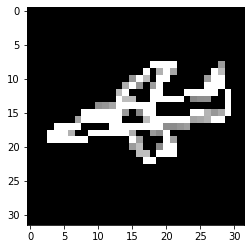

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


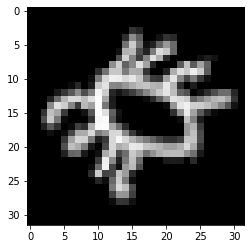

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


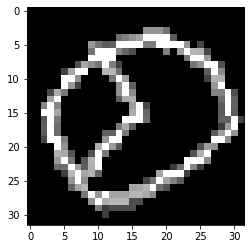

tensor(0.9979, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9979, device='cuda:0', grad_fn=<SelectBackward>)
5


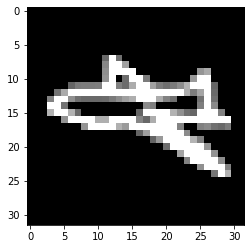

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


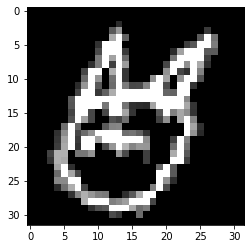

tensor(0.9293, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9148, device='cuda:0', grad_fn=<SelectBackward>)
7


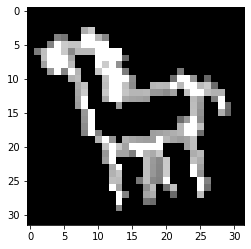

tensor(0.6200, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.6933, device='cuda:0', grad_fn=<SelectBackward>)
6


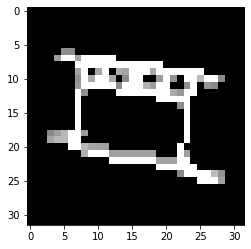

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


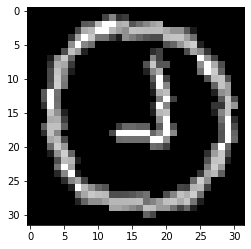

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


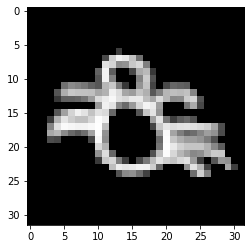

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


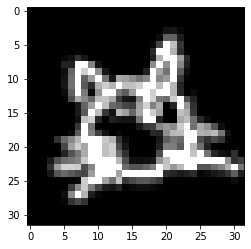

tensor(0.9985, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9992, device='cuda:0', grad_fn=<SelectBackward>)
7


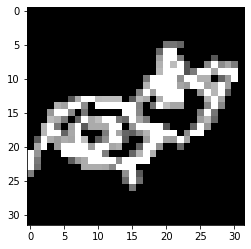

tensor(0.8090, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.8775, device='cuda:0', grad_fn=<SelectBackward>)
7


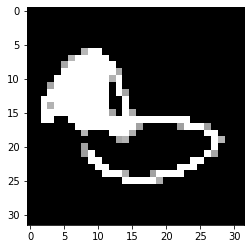

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


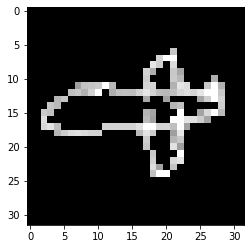

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


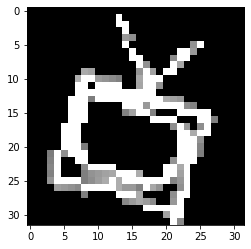

tensor(0.9696, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9626, device='cuda:0', grad_fn=<SelectBackward>)
7


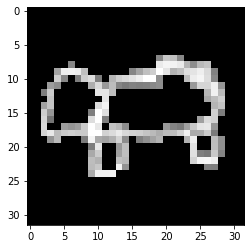

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4


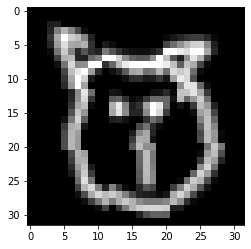

tensor(0.5007, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.5320, device='cuda:0', grad_fn=<SelectBackward>)
7


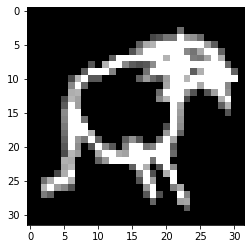

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


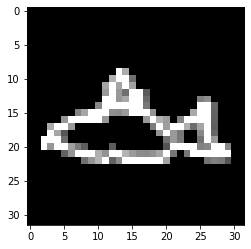

tensor(0.7023, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.8147, device='cuda:0', grad_fn=<SelectBackward>)
8


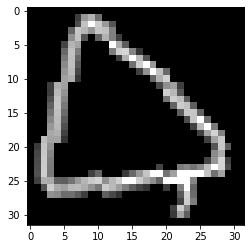

tensor(0.9813, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9800, device='cuda:0', grad_fn=<SelectBackward>)
5


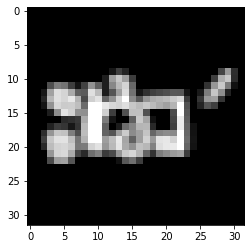

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


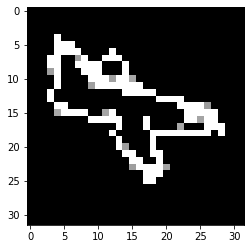

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
7


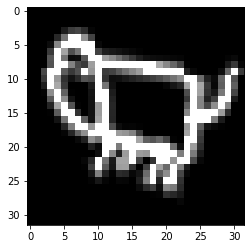

tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2


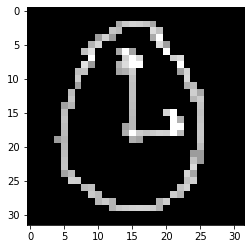

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


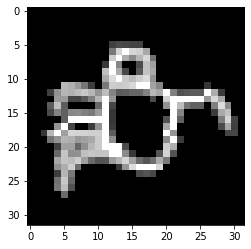

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


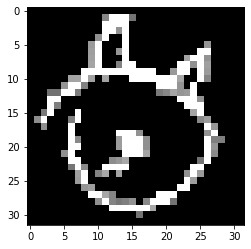

tensor(0.9970, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9972, device='cuda:0', grad_fn=<SelectBackward>)
7


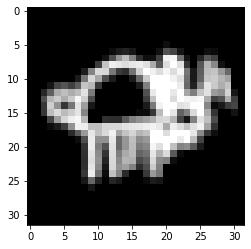

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


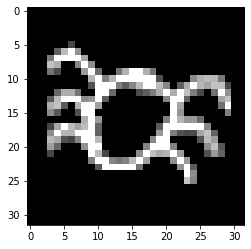

tensor(0.9984, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9979, device='cuda:0', grad_fn=<SelectBackward>)
9


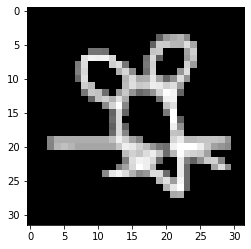

tensor(0.9988, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9987, device='cuda:0', grad_fn=<SelectBackward>)
5


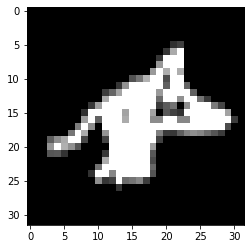

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


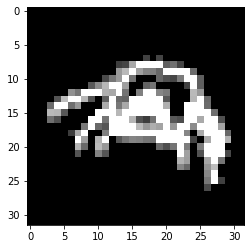

tensor(0.8314, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.8100, device='cuda:0', grad_fn=<SelectBackward>)
7


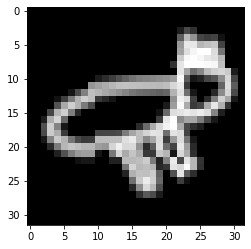

tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


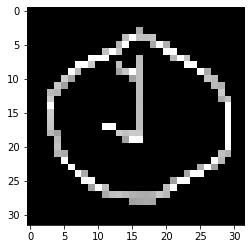

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


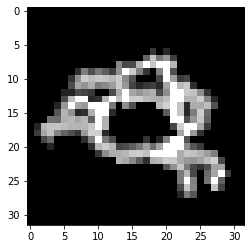

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


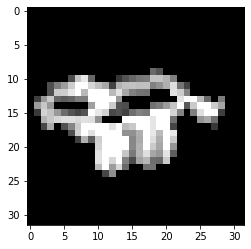

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


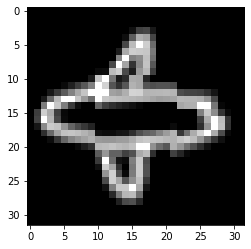

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


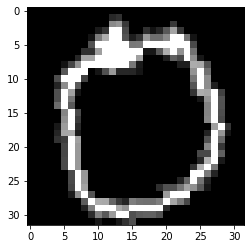

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


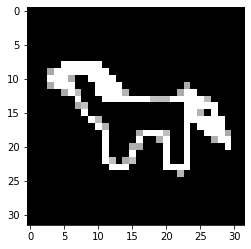

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8


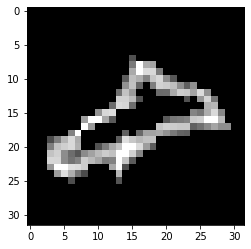

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


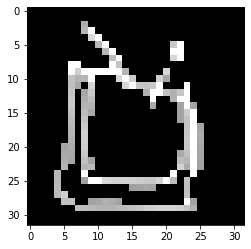

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


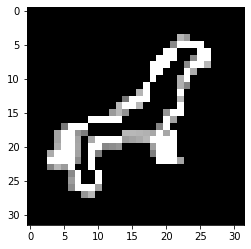

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


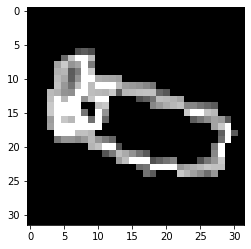

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


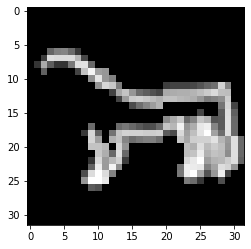

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


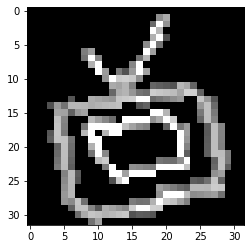

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


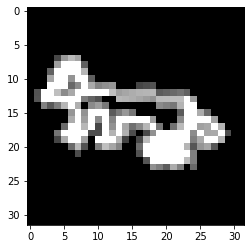

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


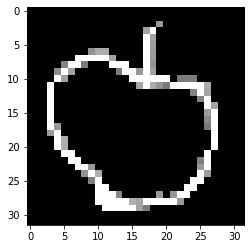

tensor(0.7415, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.8143, device='cuda:0', grad_fn=<SelectBackward>)
5


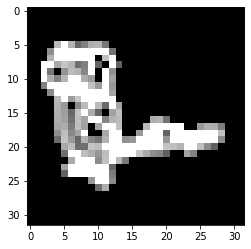

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


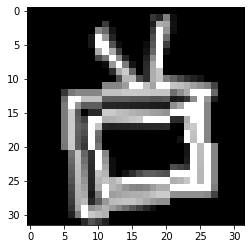

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


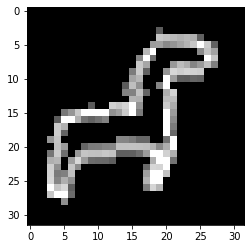

tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
5


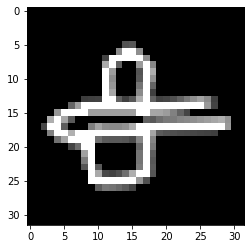

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


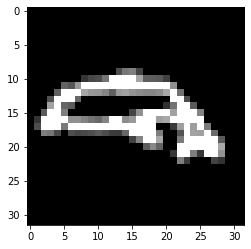

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
7


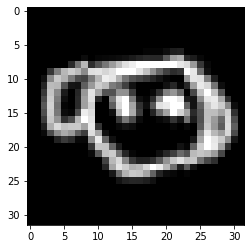

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


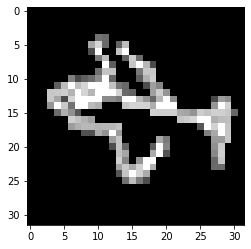

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
5


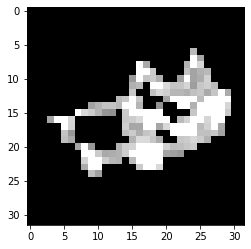

tensor(0.9981, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9985, device='cuda:0', grad_fn=<SelectBackward>)
5


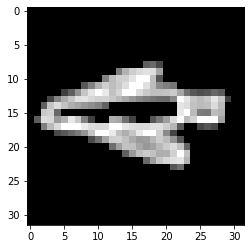

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


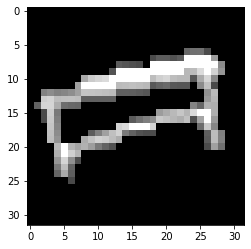

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
8


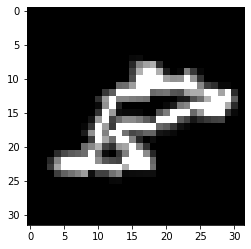

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


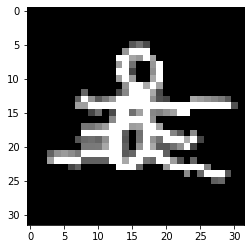

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


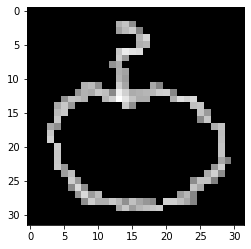

tensor(0.9937, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9952, device='cuda:0', grad_fn=<SelectBackward>)
0


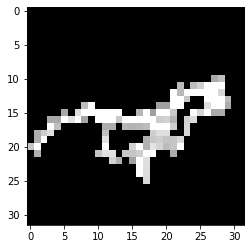

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


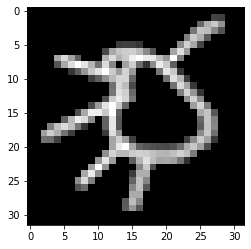

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


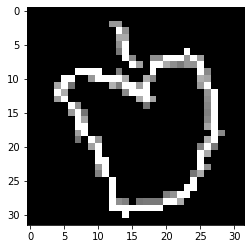

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


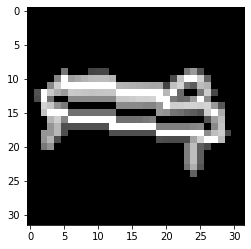

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


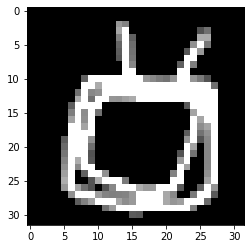

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


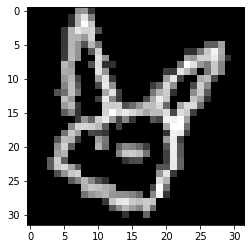

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


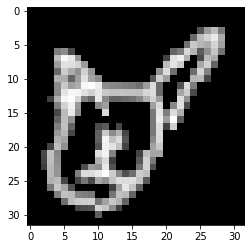

tensor(0.9071, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(0.8884, device='cuda:0', grad_fn=<SelectBackward>)
2


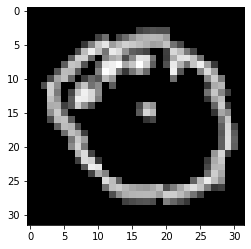

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


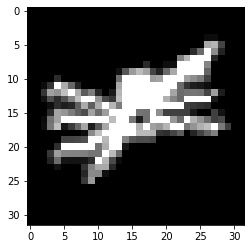

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


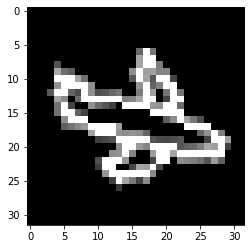

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
5


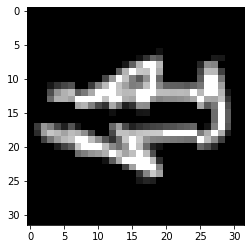

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


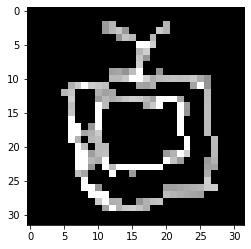

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


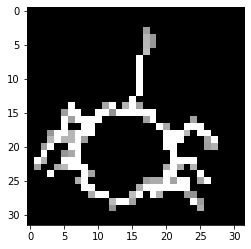

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


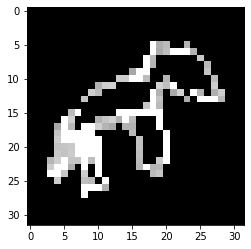

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


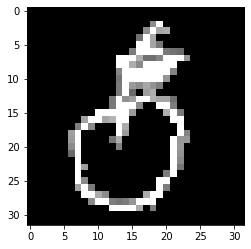

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


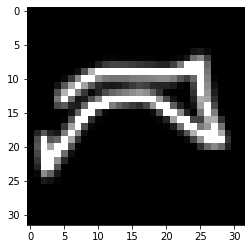

tensor(0.9989, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9992, device='cuda:0', grad_fn=<SelectBackward>)
7


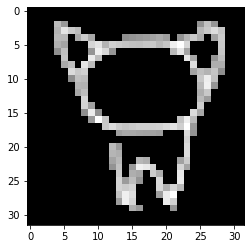

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


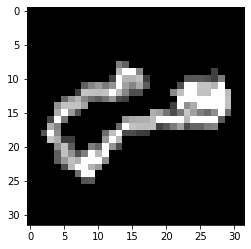

tensor(0.4885, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.4862, device='cuda:0', grad_fn=<SelectBackward>)
0


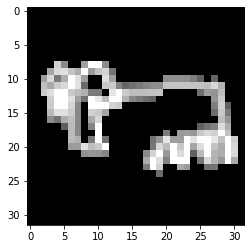

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
7


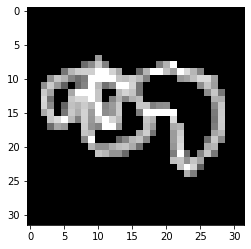

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


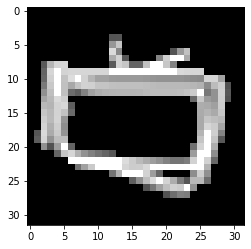

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
0


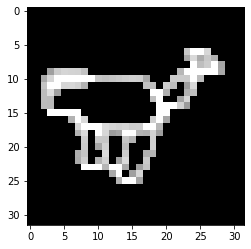

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7


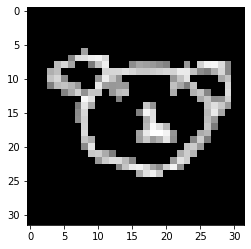

tensor(0.9381, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9496, device='cuda:0', grad_fn=<SelectBackward>)
7


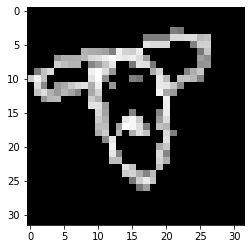

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


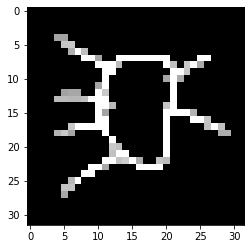

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


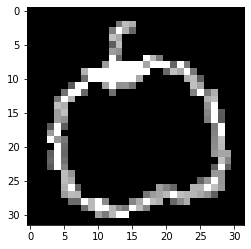

tensor(0.9914, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(0.9903, device='cuda:0', grad_fn=<SelectBackward>)
2


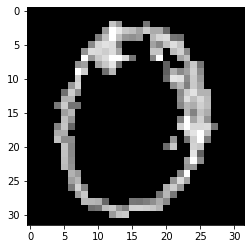

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


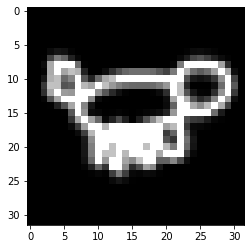

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


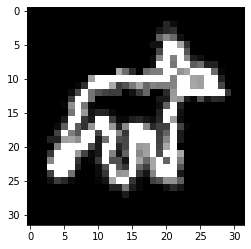

tensor(0.9957, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9946, device='cuda:0', grad_fn=<SelectBackward>)
7


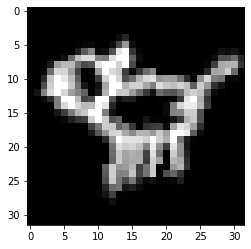

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


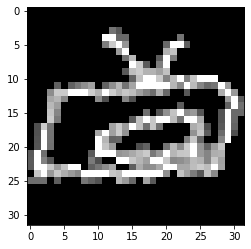

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


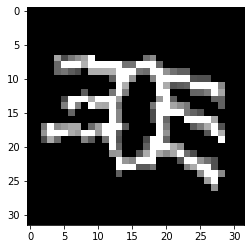

tensor(0.9811, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9687, device='cuda:0', grad_fn=<SelectBackward>)
7


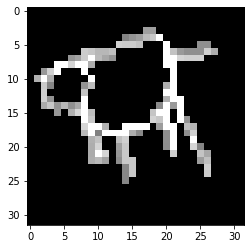

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4


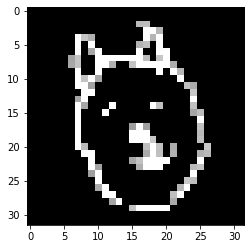

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


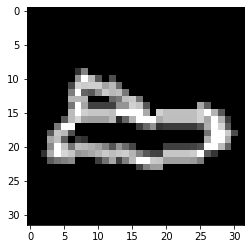

tensor(0.9645, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9732, device='cuda:0', grad_fn=<SelectBackward>)
7


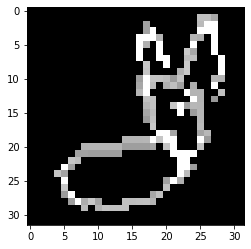

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
1


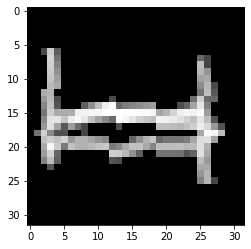

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


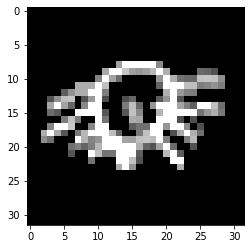

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


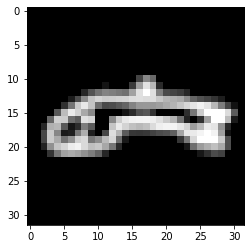

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


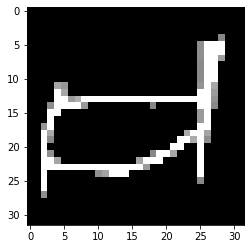

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


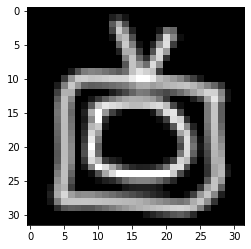

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


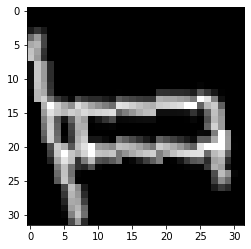

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


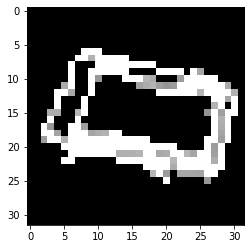

tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2


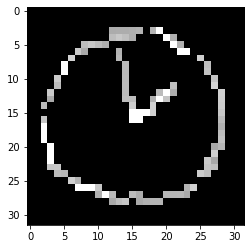

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
9


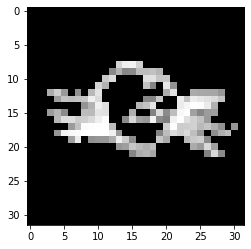

tensor(0.9565, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9693, device='cuda:0', grad_fn=<SelectBackward>)
8


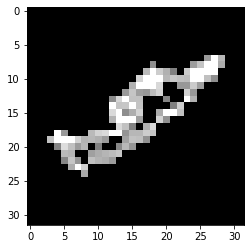

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


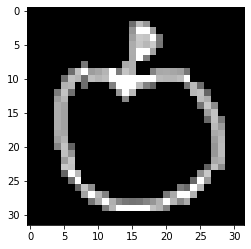

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


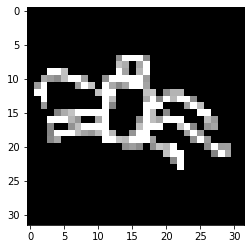

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


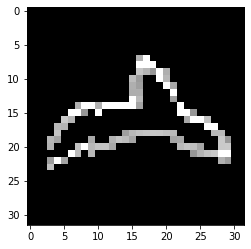

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
9


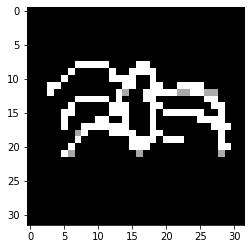

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


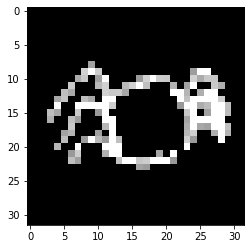

tensor(0.7352, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.7521, device='cuda:0', grad_fn=<SelectBackward>)
0


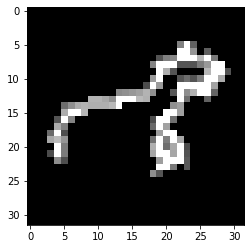

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


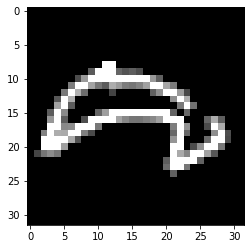

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


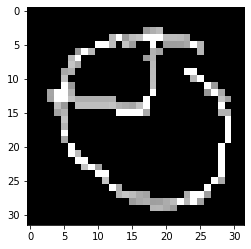

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


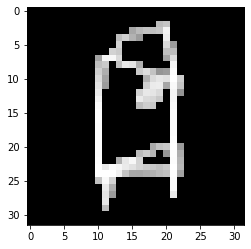

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


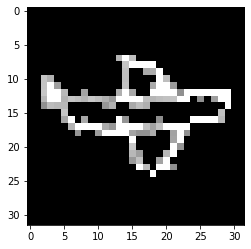

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
8


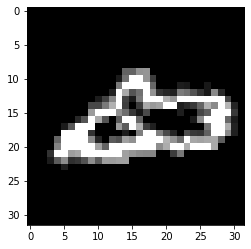

tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9993, device='cuda:0', grad_fn=<SelectBackward>)
8


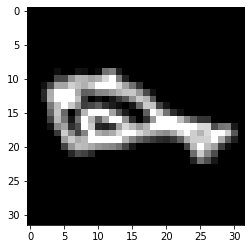

tensor(0.9086, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9325, device='cuda:0', grad_fn=<SelectBackward>)
7


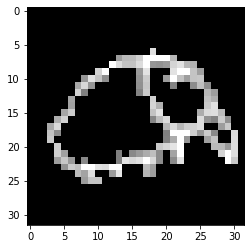

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


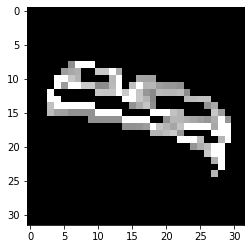

tensor(0.9970, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9974, device='cuda:0', grad_fn=<SelectBackward>)
7


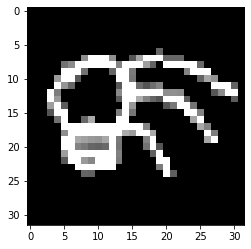

tensor(0.9980, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9986, device='cuda:0', grad_fn=<SelectBackward>)
8


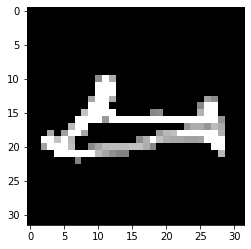

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


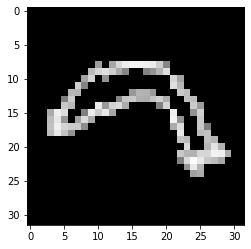

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


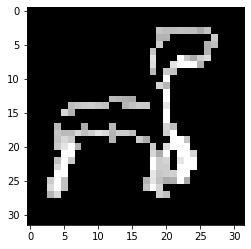

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


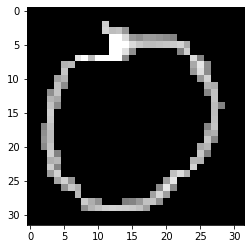

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


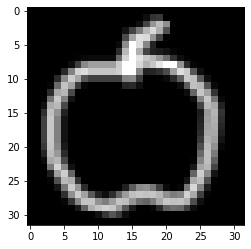

tensor(0.9988, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9991, device='cuda:0', grad_fn=<SelectBackward>)
0


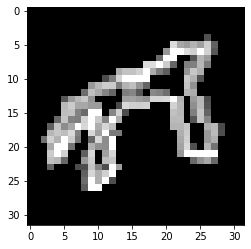

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


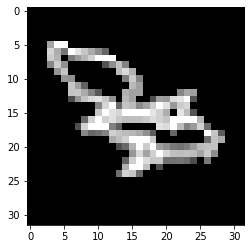

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


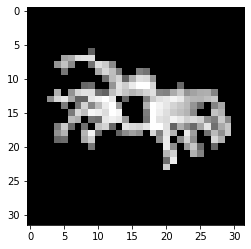

tensor(0.9921, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9930, device='cuda:0', grad_fn=<SelectBackward>)
0


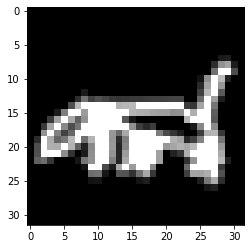

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


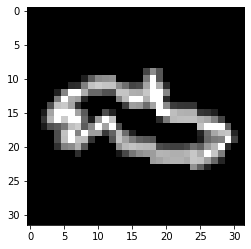

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


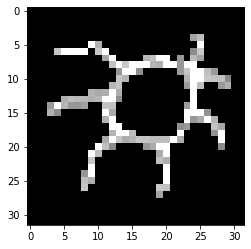

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


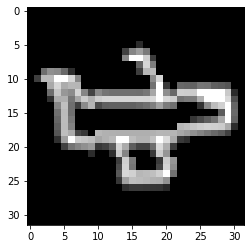

tensor(0.9071, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.8592, device='cuda:0', grad_fn=<SelectBackward>)
4


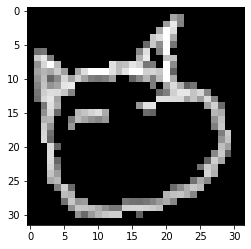

tensor(0.9964, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9971, device='cuda:0', grad_fn=<SelectBackward>)
7


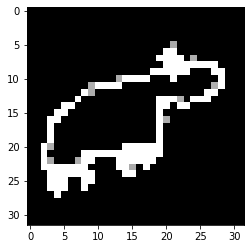

tensor(0.9815, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9875, device='cuda:0', grad_fn=<SelectBackward>)
7


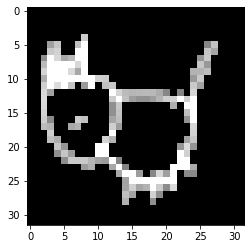

tensor(0.9986, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9984, device='cuda:0', grad_fn=<SelectBackward>)
8


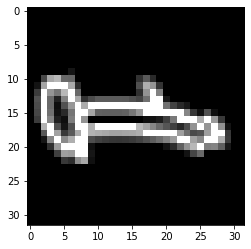

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


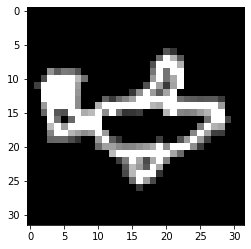

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
0


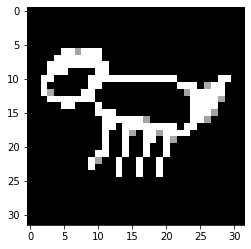

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


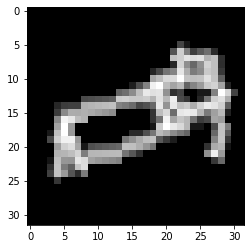

tensor(0.8615, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.8860, device='cuda:0', grad_fn=<SelectBackward>)
0


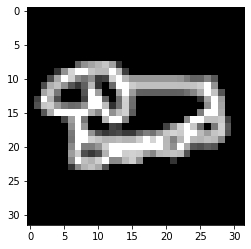

tensor(0.9841, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9859, device='cuda:0', grad_fn=<SelectBackward>)
4


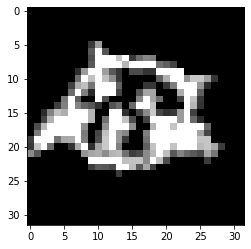

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


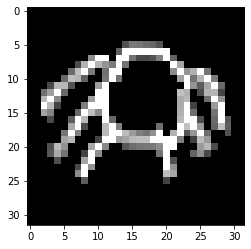

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


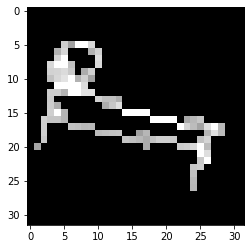

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


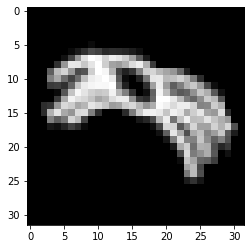

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


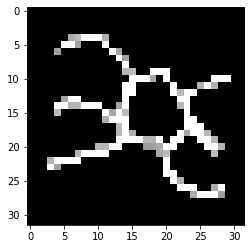

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


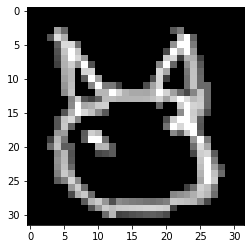

tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
1


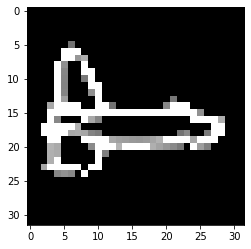

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
1


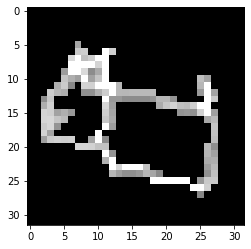

tensor(0.8066, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.7428, device='cuda:0', grad_fn=<SelectBackward>)
7


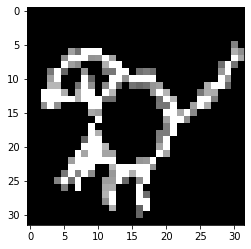

tensor(0.9311, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9354, device='cuda:0', grad_fn=<SelectBackward>)
7


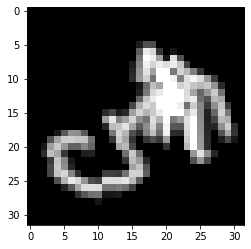

tensor(0.9585, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9607, device='cuda:0', grad_fn=<SelectBackward>)
5


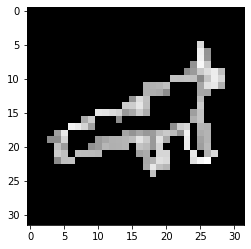

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


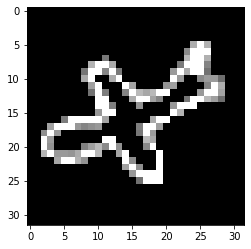

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


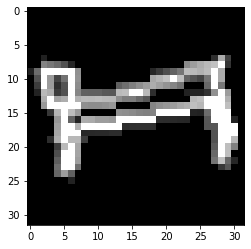

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


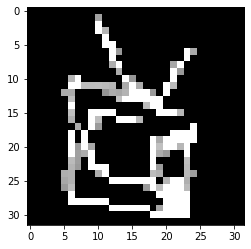

tensor(0.9957, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9957, device='cuda:0', grad_fn=<SelectBackward>)
0


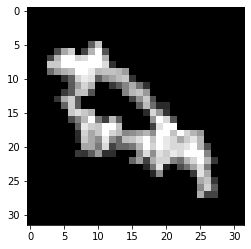

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


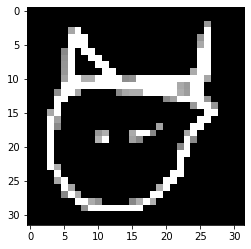

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


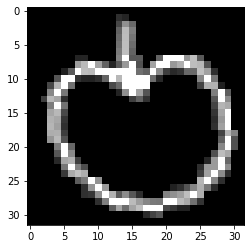

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


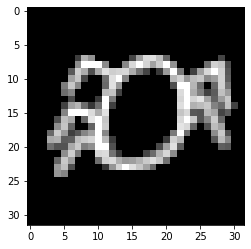

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


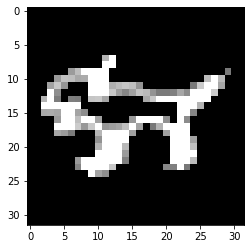

tensor(0.9702, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9836, device='cuda:0', grad_fn=<SelectBackward>)
9


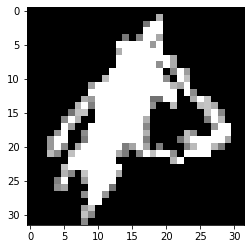

tensor(0.8817, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(0.8840, device='cuda:0', grad_fn=<SelectBackward>)
3


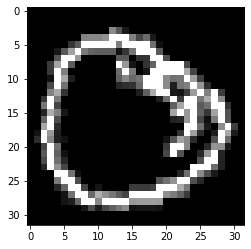

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


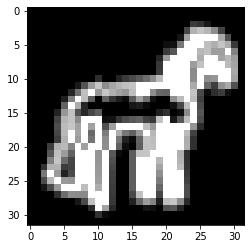

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


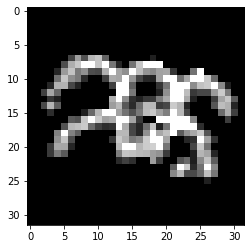

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


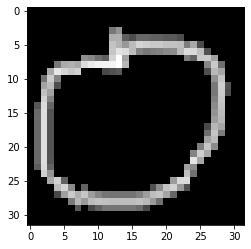

tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9993, device='cuda:0', grad_fn=<SelectBackward>)
8


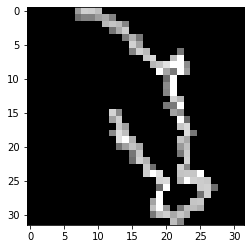

tensor(0.9953, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9967, device='cuda:0', grad_fn=<SelectBackward>)
5


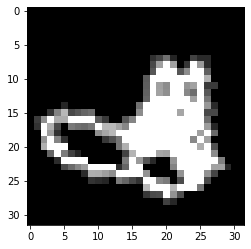

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


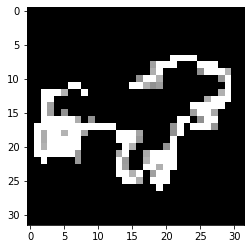

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


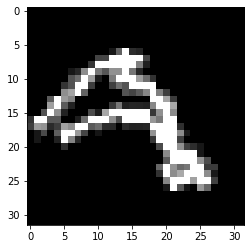

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


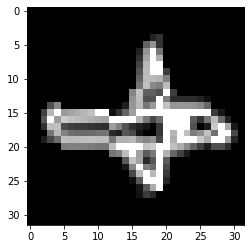

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


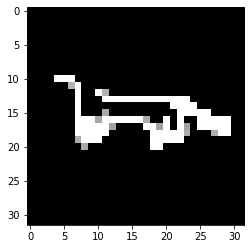

tensor(0.9677, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9839, device='cuda:0', grad_fn=<SelectBackward>)
7


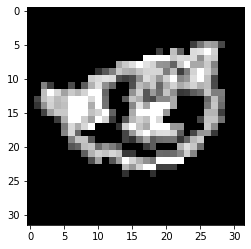

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


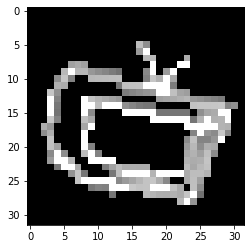

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


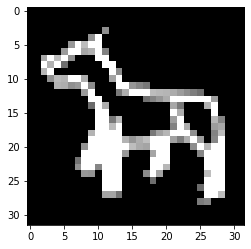

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9993, device='cuda:0', grad_fn=<SelectBackward>)
8


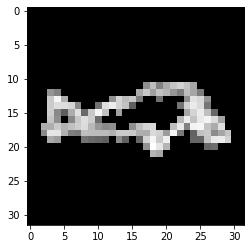

tensor(0.9977, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9976, device='cuda:0', grad_fn=<SelectBackward>)
5


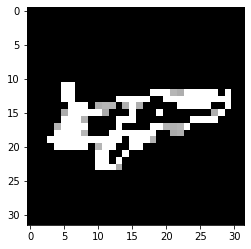

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


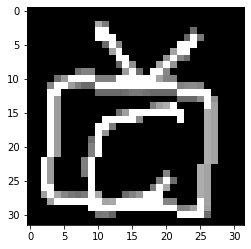

tensor(0.9485, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9572, device='cuda:0', grad_fn=<SelectBackward>)
7


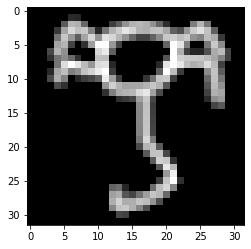

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


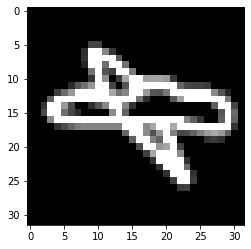

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


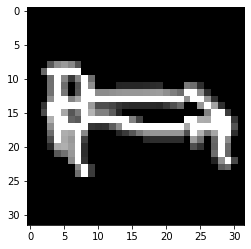

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
0


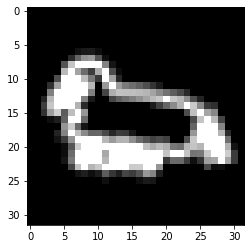

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


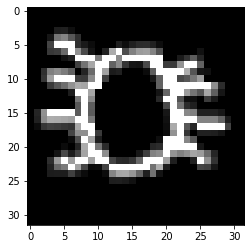

tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
7


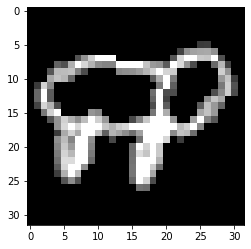

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


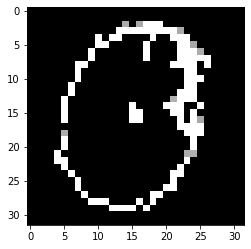

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


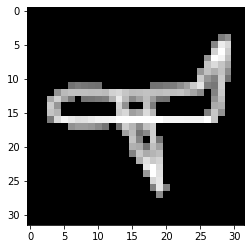

tensor(0.9934, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9950, device='cuda:0', grad_fn=<SelectBackward>)
9


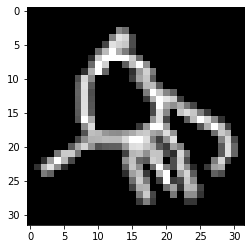

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


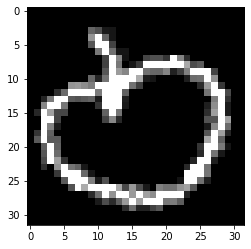

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7


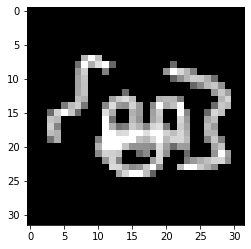

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


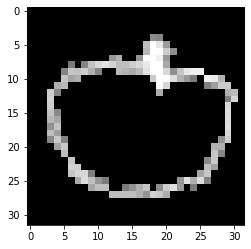

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


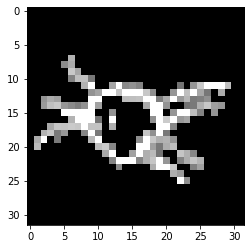

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


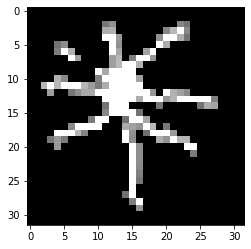

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


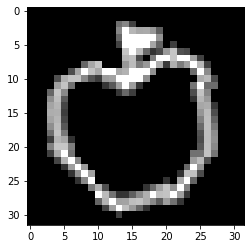

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


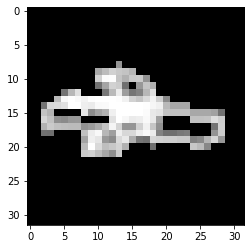

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
1


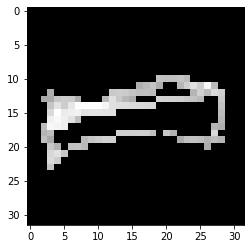

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4


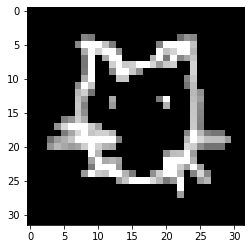

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


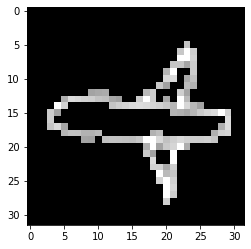

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
0


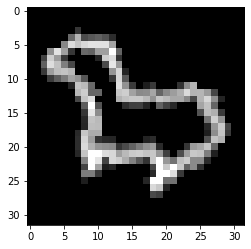

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


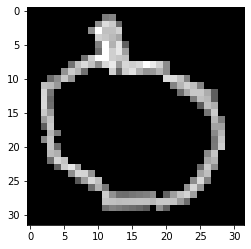

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


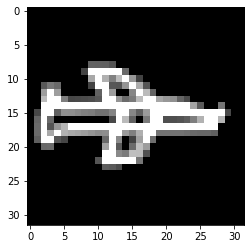

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


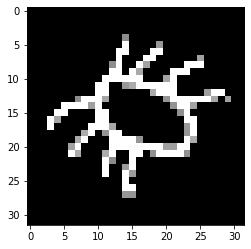

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


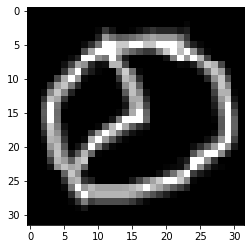

tensor(0.8040, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.7727, device='cuda:0', grad_fn=<SelectBackward>)
5


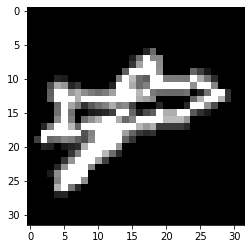

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


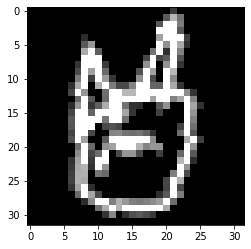

tensor(0.5685, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.5081, device='cuda:0', grad_fn=<SelectBackward>)
0


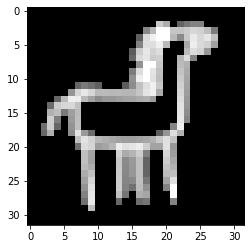

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
6


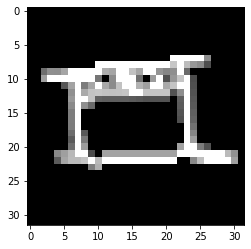

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


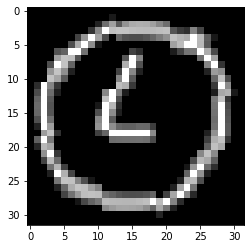

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


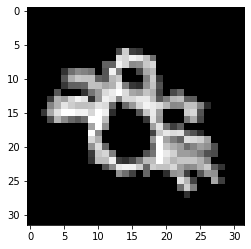

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
4


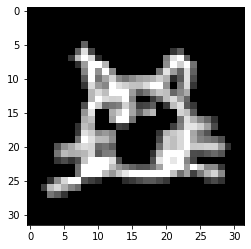

tensor(0.9981, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9987, device='cuda:0', grad_fn=<SelectBackward>)
7


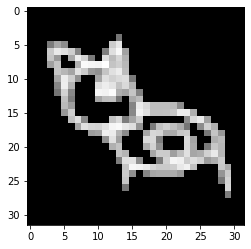

tensor(0.9944, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9956, device='cuda:0', grad_fn=<SelectBackward>)
7


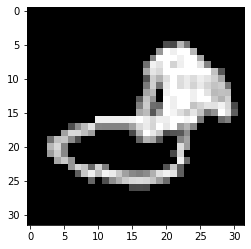

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


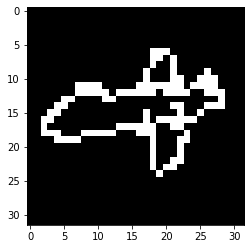

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


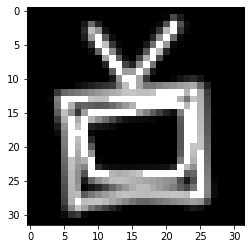

tensor(0.9360, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9344, device='cuda:0', grad_fn=<SelectBackward>)
7


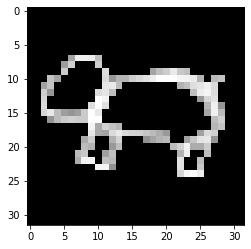

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
4


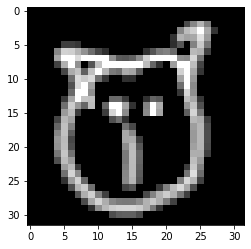

tensor(0.9647, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9678, device='cuda:0', grad_fn=<SelectBackward>)
9


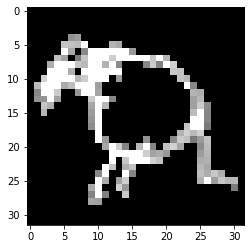

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


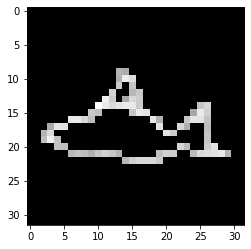

tensor(0.9968, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9965, device='cuda:0', grad_fn=<SelectBackward>)
1


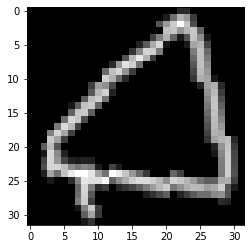

tensor(0.9883, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9870, device='cuda:0', grad_fn=<SelectBackward>)
5


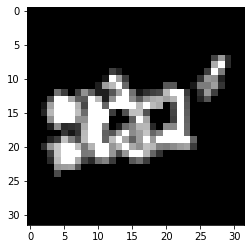

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


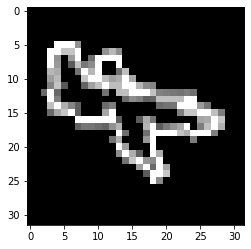

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
7


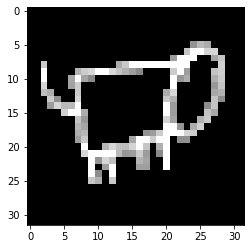

tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2


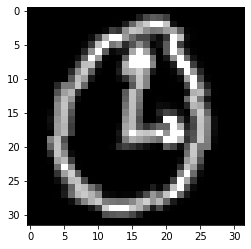

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


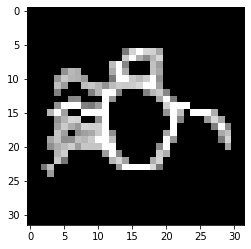

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


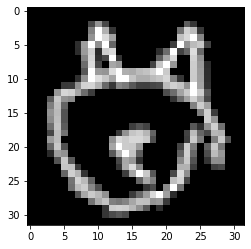

tensor(0.9969, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9980, device='cuda:0', grad_fn=<SelectBackward>)
7


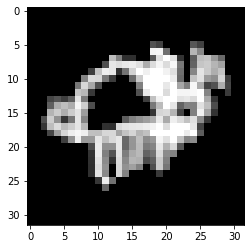

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


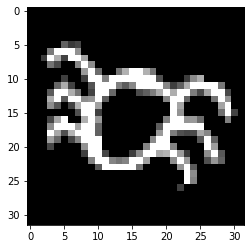

tensor(0.9962, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9963, device='cuda:0', grad_fn=<SelectBackward>)
9


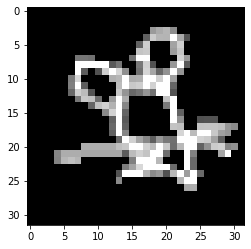

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


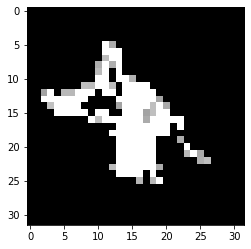

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


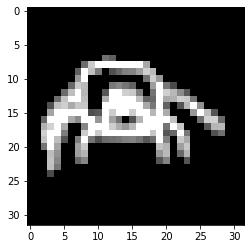

tensor(0.6509, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.5798, device='cuda:0', grad_fn=<SelectBackward>)
7


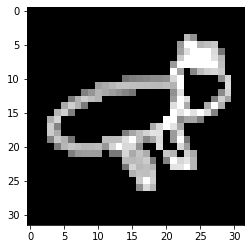

tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


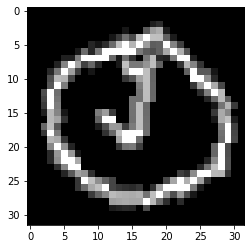

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


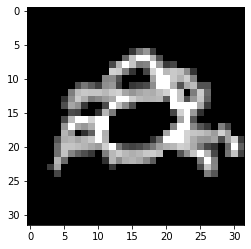

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


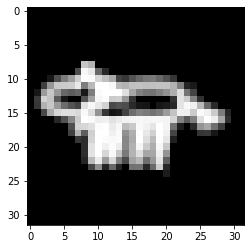

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


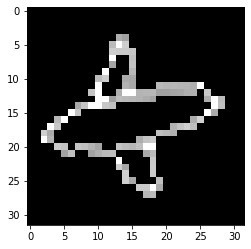

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


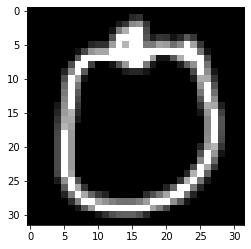

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


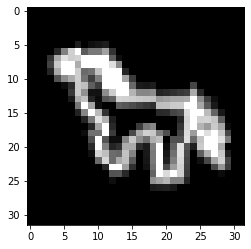

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


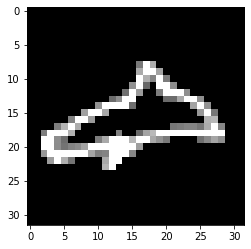

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


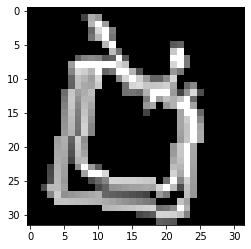

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


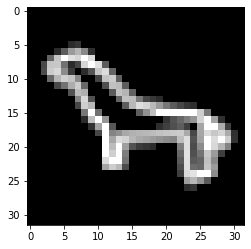

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


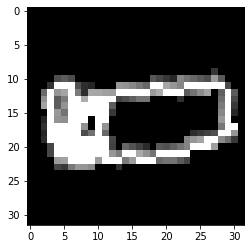

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


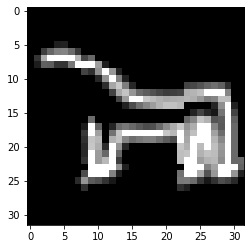

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


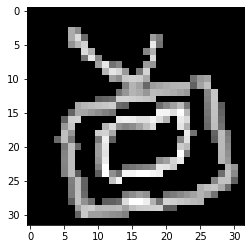

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


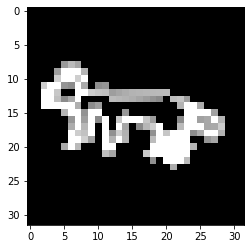

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


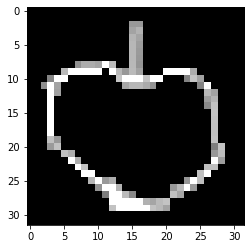

tensor(0.9545, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9649, device='cuda:0', grad_fn=<SelectBackward>)
5


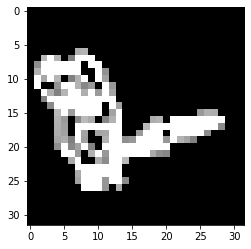

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


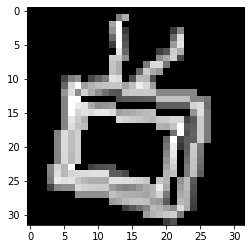

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


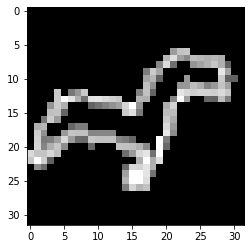

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
5


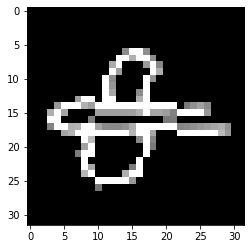

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


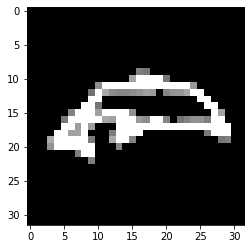

tensor(0.9992, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9988, device='cuda:0', grad_fn=<SelectBackward>)
7


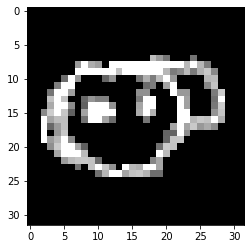

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


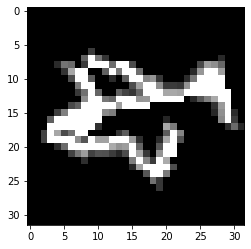

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
5


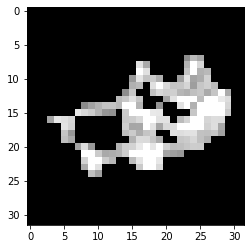

tensor(0.9933, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9936, device='cuda:0', grad_fn=<SelectBackward>)
5


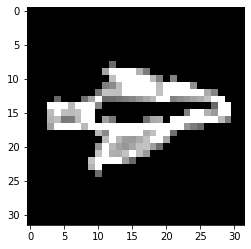

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


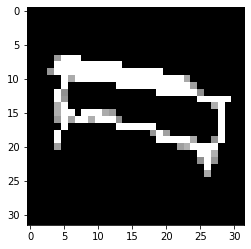

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


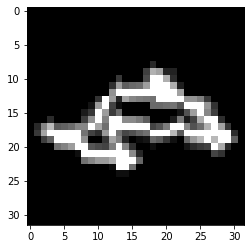

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


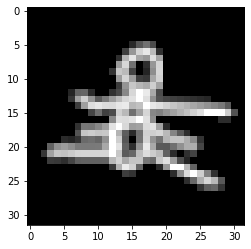

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


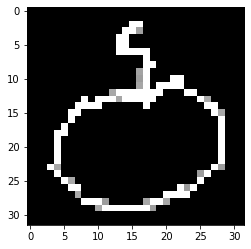

tensor(0.9971, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9972, device='cuda:0', grad_fn=<SelectBackward>)
0


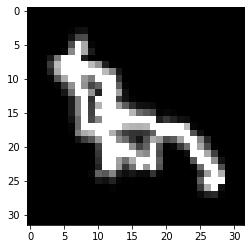

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


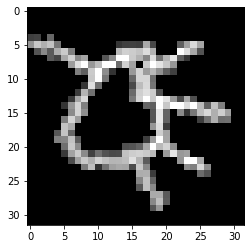

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


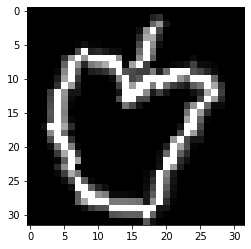

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


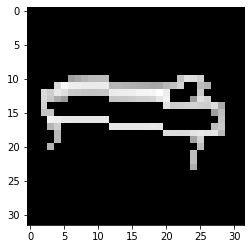

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


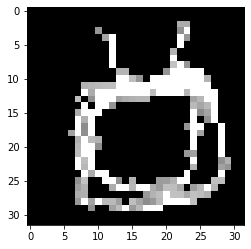

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


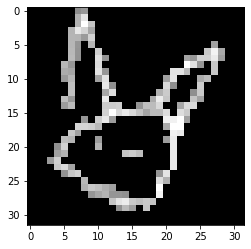

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
4


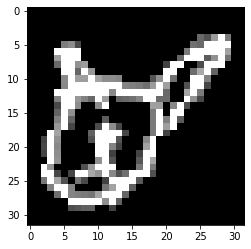

tensor(0.9914, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(0.9916, device='cuda:0', grad_fn=<SelectBackward>)
2


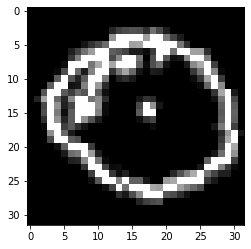

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


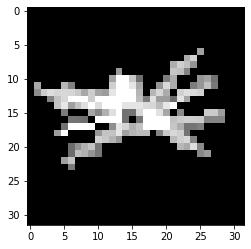

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


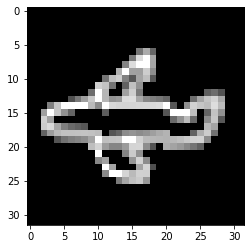

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


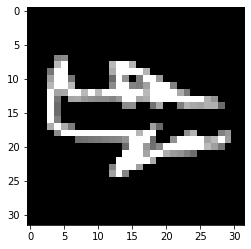

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


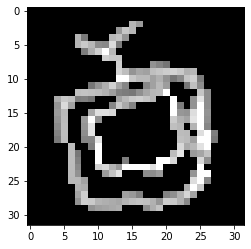

tensor(0.9987, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9991, device='cuda:0', grad_fn=<SelectBackward>)
9


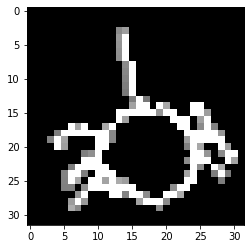

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


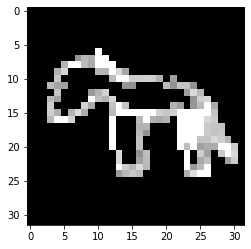

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


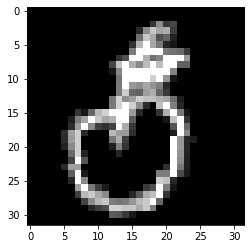

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


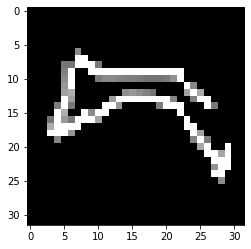

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
7


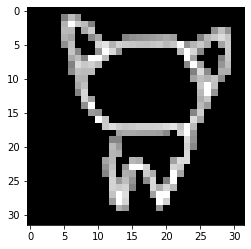

tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
8


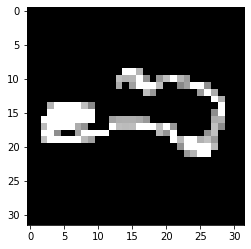

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
7


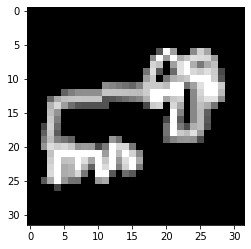

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7


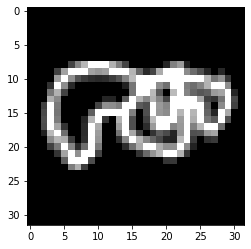

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


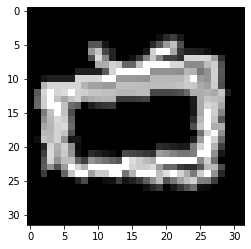

tensor(0.9984, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9987, device='cuda:0', grad_fn=<SelectBackward>)
0


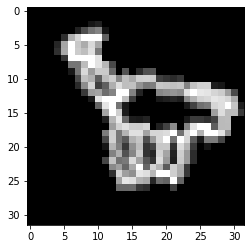

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
7


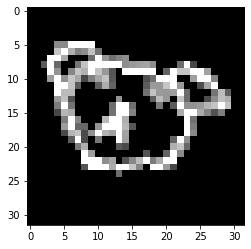

tensor(0.8445, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(0.8147, device='cuda:0', grad_fn=<SelectBackward>)
3


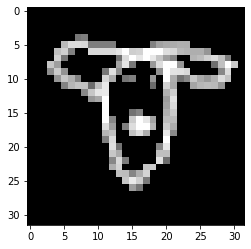

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


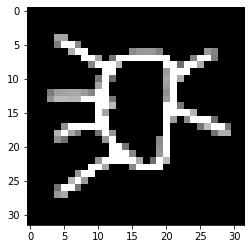

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


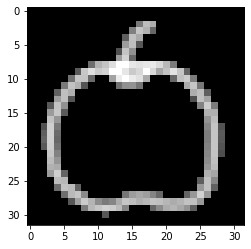

tensor(0.8553, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(0.8524, device='cuda:0', grad_fn=<SelectBackward>)
2


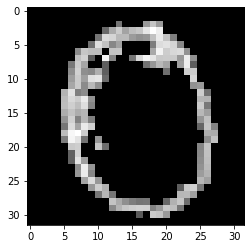

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


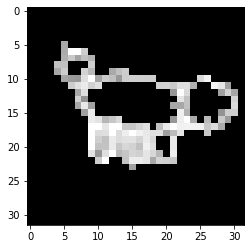

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


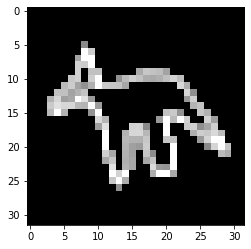

tensor(0.9970, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9973, device='cuda:0', grad_fn=<SelectBackward>)
7


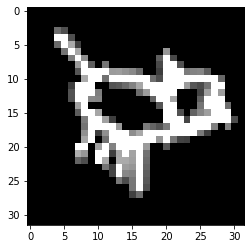

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
6


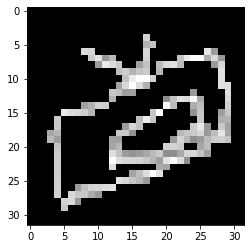

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


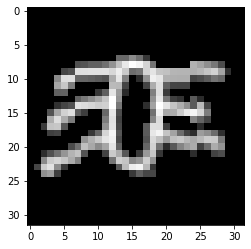

tensor(0.9021, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.8390, device='cuda:0', grad_fn=<SelectBackward>)
7


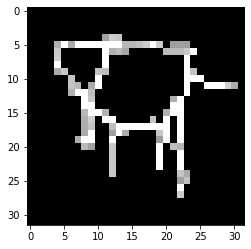

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4


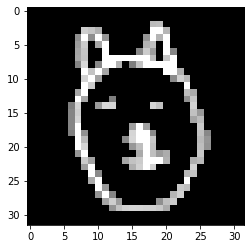

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


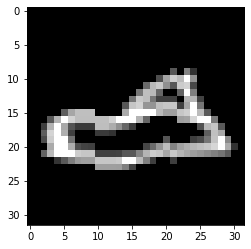

tensor(0.9543, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9642, device='cuda:0', grad_fn=<SelectBackward>)
7


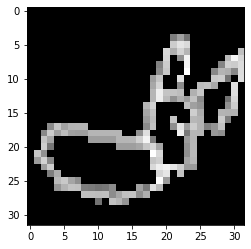

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


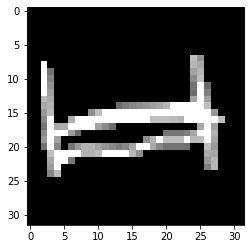

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


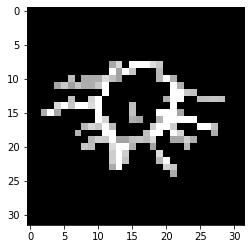

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


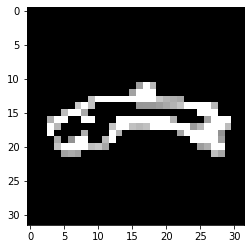

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


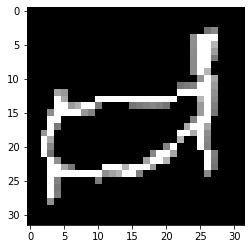

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


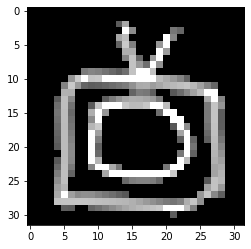

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


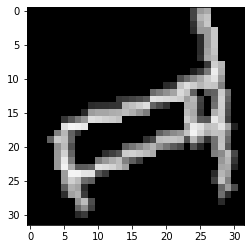

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


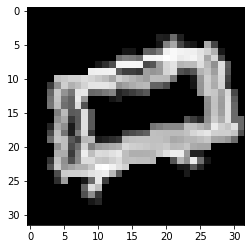

tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2


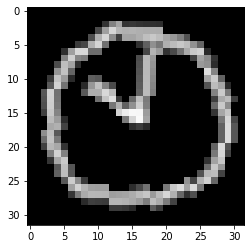

tensor(0.9989, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9989, device='cuda:0', grad_fn=<SelectBackward>)
9


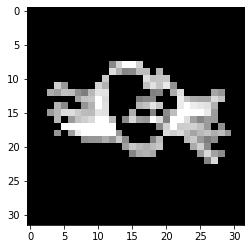

tensor(0.8643, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.8950, device='cuda:0', grad_fn=<SelectBackward>)
8


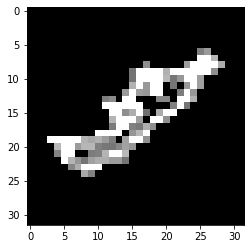

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


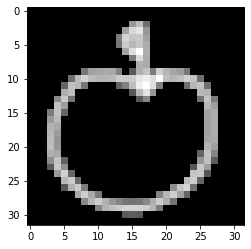

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


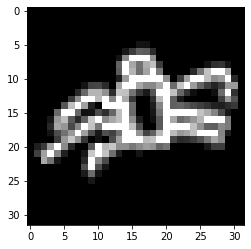

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


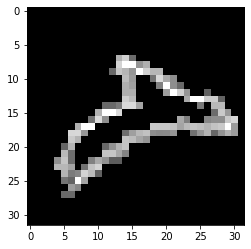

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


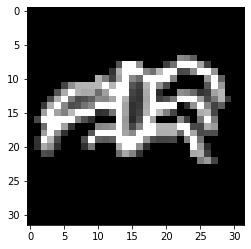

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


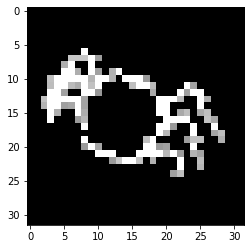

tensor(0.6761, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.7154, device='cuda:0', grad_fn=<SelectBackward>)
0


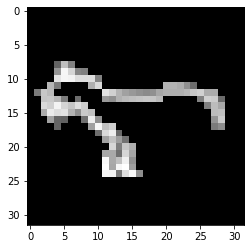

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


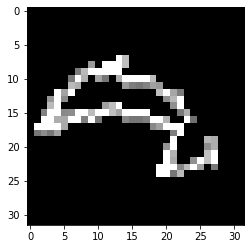

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
2


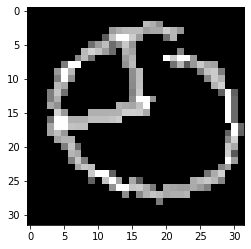

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
6


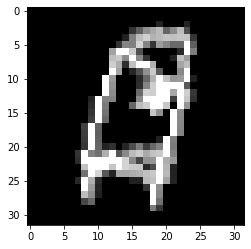

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


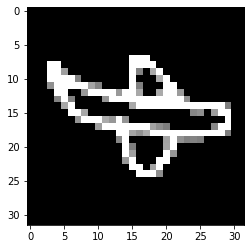

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


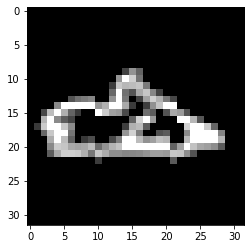

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
8


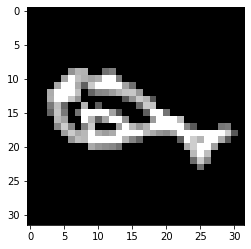

tensor(0.8732, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.8598, device='cuda:0', grad_fn=<SelectBackward>)
9


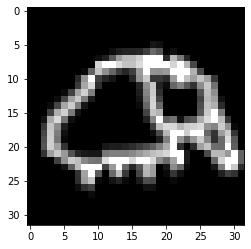

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


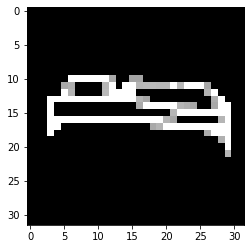

tensor(0.9993, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
7


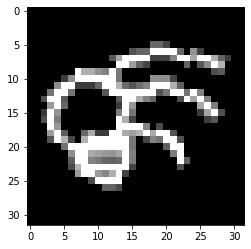

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


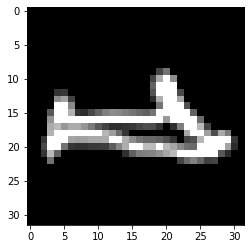

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


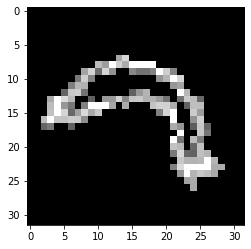

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


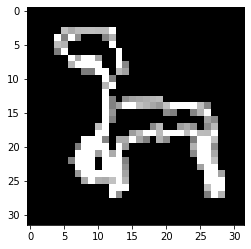

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


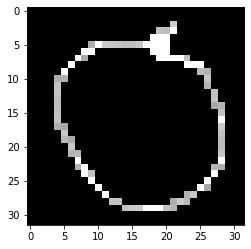

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


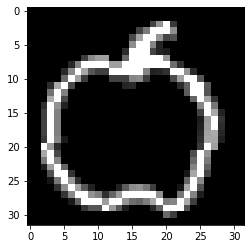

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


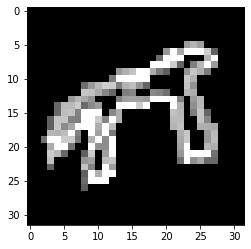

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


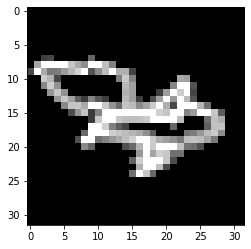

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


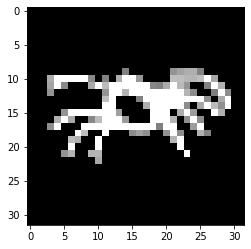

tensor(0.9397, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9511, device='cuda:0', grad_fn=<SelectBackward>)
0


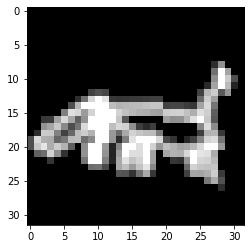

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


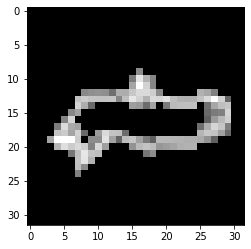

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


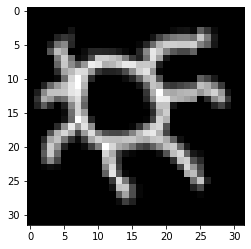

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


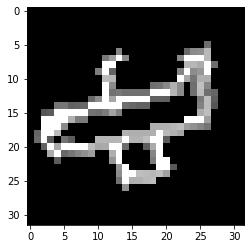

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
4


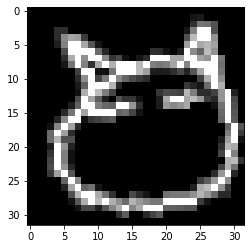

tensor(0.9987, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9989, device='cuda:0', grad_fn=<SelectBackward>)
7


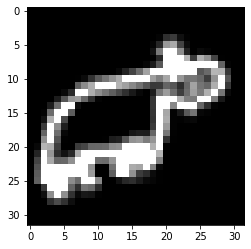

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
7


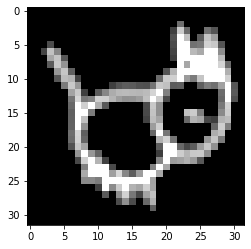

tensor(0.8787, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.8758, device='cuda:0', grad_fn=<SelectBackward>)
8


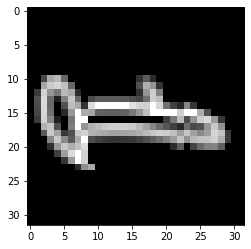

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


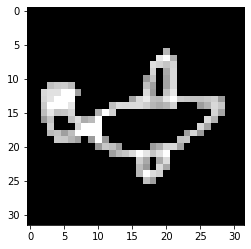

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


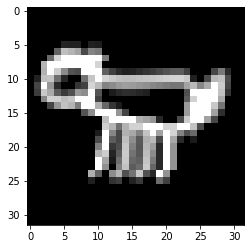

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


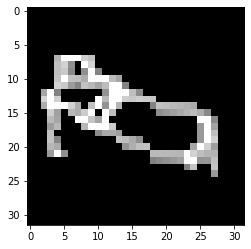

tensor(0.7996, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.8468, device='cuda:0', grad_fn=<SelectBackward>)
0


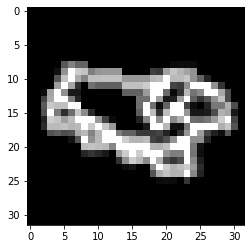

tensor(0.9985, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9980, device='cuda:0', grad_fn=<SelectBackward>)
4


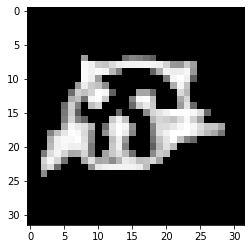

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


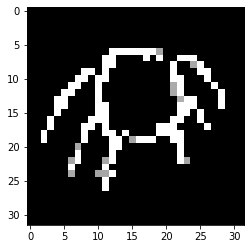

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


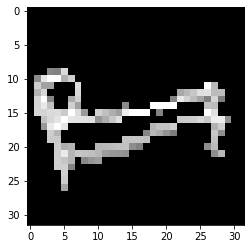

tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
9


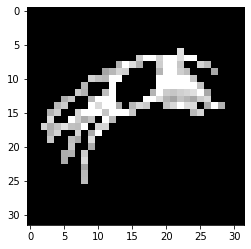

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


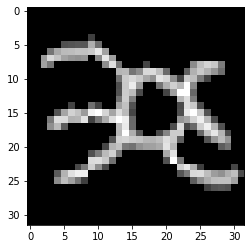

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


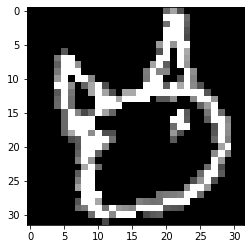

tensor(0.9928, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9864, device='cuda:0', grad_fn=<SelectBackward>)
1


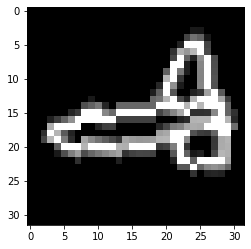

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
1


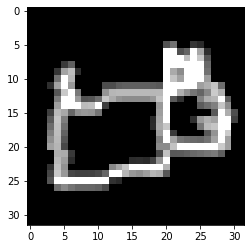

tensor(0.8106, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.8313, device='cuda:0', grad_fn=<SelectBackward>)
9


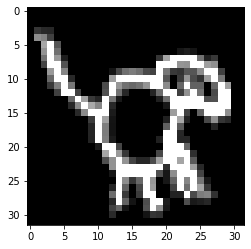

tensor(0.9620, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9680, device='cuda:0', grad_fn=<SelectBackward>)
7


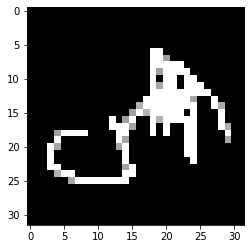

tensor(0.8448, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.8940, device='cuda:0', grad_fn=<SelectBackward>)
5


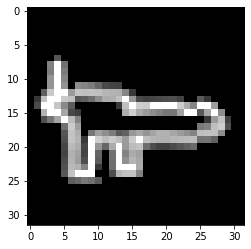

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


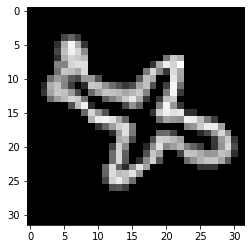

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


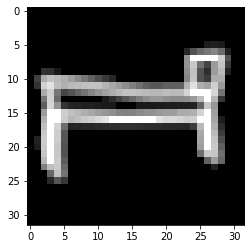

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


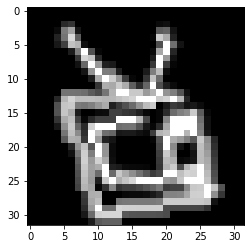

tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
0


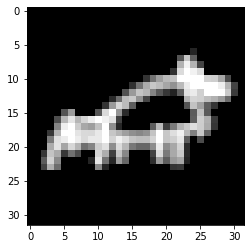

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


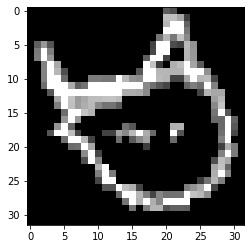

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


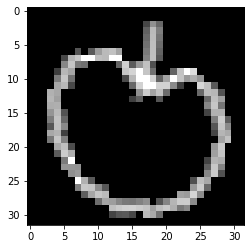

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


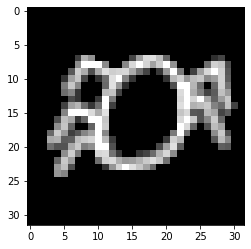

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


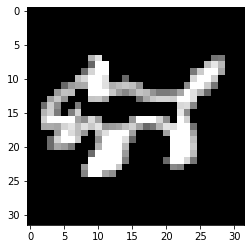

tensor(0.9871, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9895, device='cuda:0', grad_fn=<SelectBackward>)
9


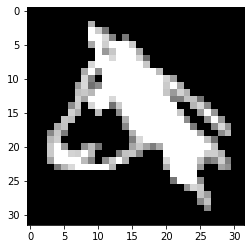

tensor(0.9993, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(0.9992, device='cuda:0', grad_fn=<SelectBackward>)
2


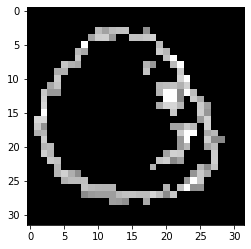

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


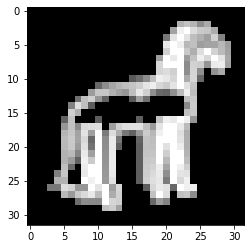

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


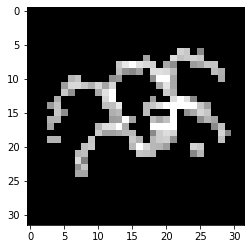

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


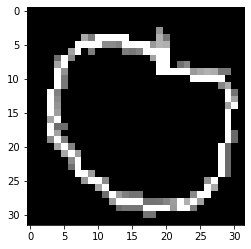

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


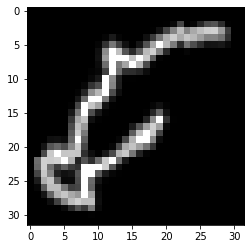

tensor(0.9914, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9931, device='cuda:0', grad_fn=<SelectBackward>)
5


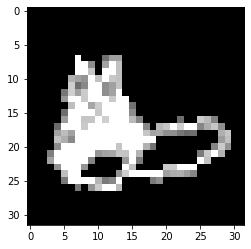

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


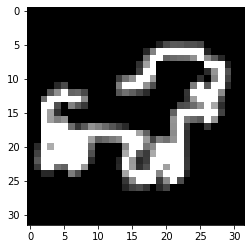

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


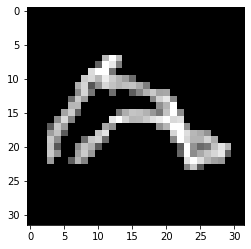

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


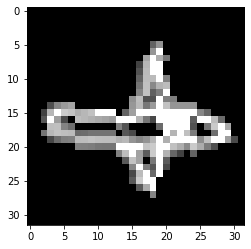

tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9993, device='cuda:0', grad_fn=<SelectBackward>)
8


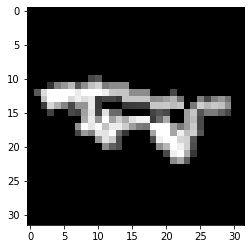

tensor(0.8471, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.8784, device='cuda:0', grad_fn=<SelectBackward>)
7


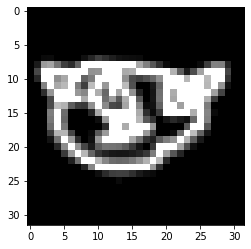

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


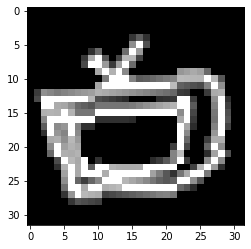

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


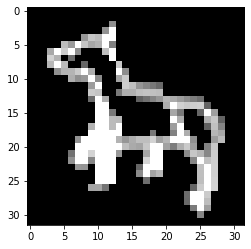

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


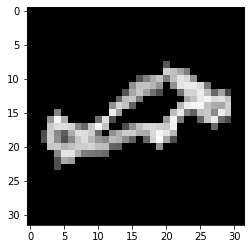

tensor(0.9934, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9908, device='cuda:0', grad_fn=<SelectBackward>)
5


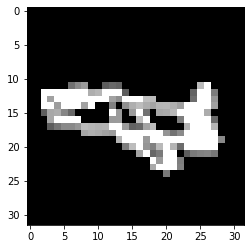

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


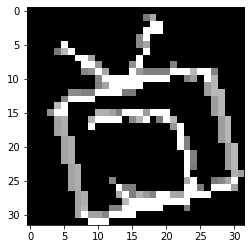

tensor(0.9448, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9498, device='cuda:0', grad_fn=<SelectBackward>)
7


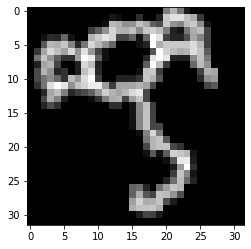

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


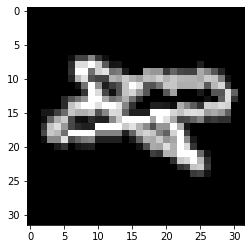

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


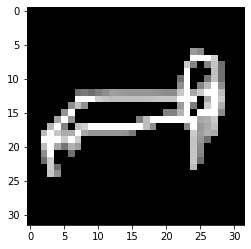

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
0


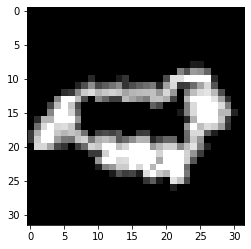

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


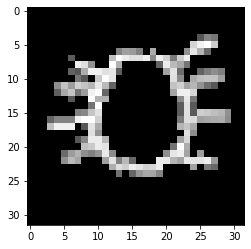

tensor(0.9993, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
7


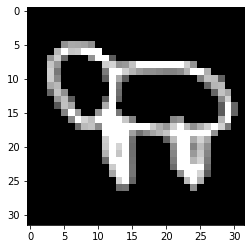

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


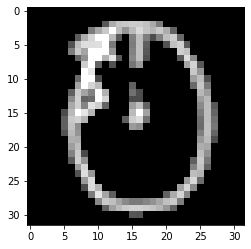

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


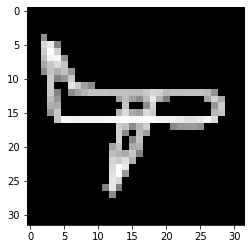

tensor(0.9996, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
9


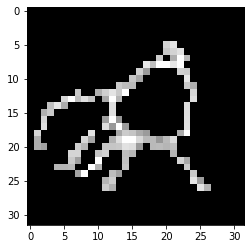

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


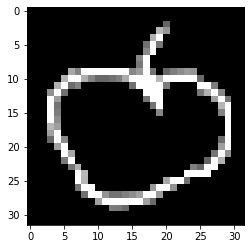

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
7


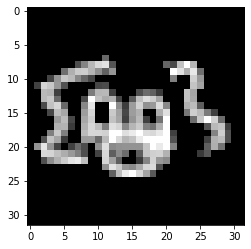

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


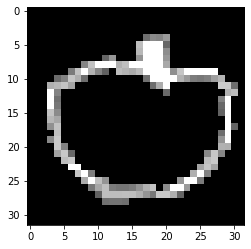

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


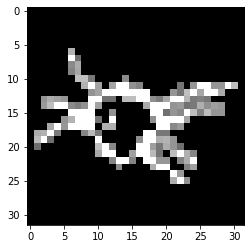

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


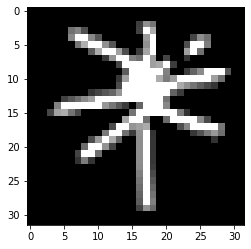

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


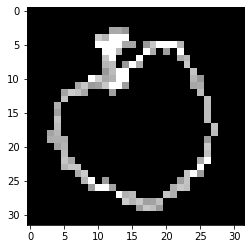

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


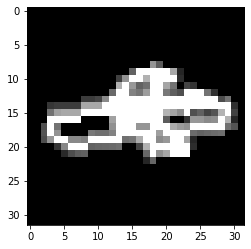

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


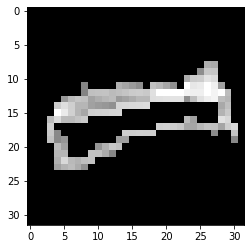

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4


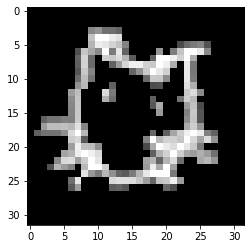

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


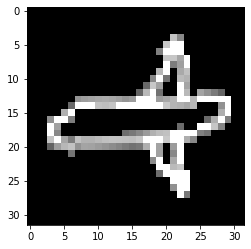

tensor(0.9997, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
0


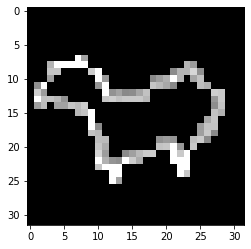

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


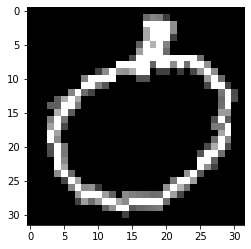

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


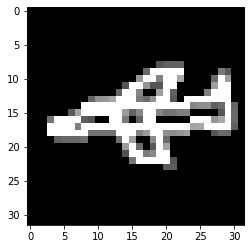

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


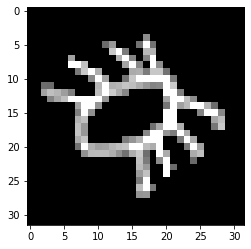

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


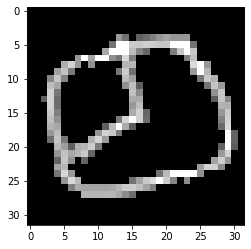

tensor(0.9991, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9990, device='cuda:0', grad_fn=<SelectBackward>)
5


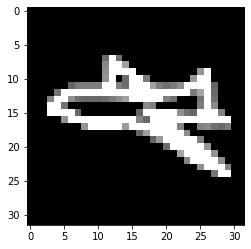

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
4


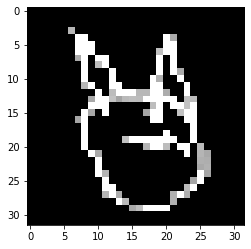

tensor(0.9748, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9754, device='cuda:0', grad_fn=<SelectBackward>)
7


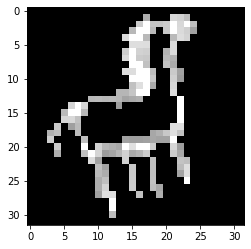

tensor(0.9929, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9942, device='cuda:0', grad_fn=<SelectBackward>)
6


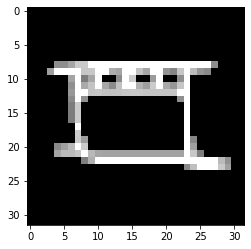

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


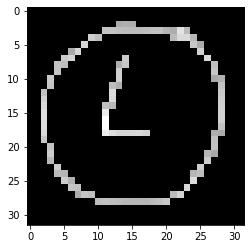

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


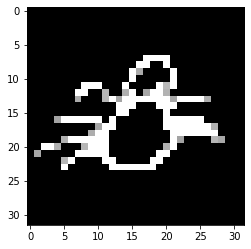

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
4


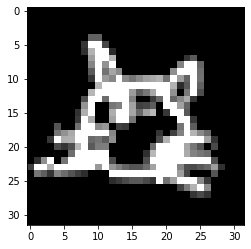

tensor(0.9977, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9982, device='cuda:0', grad_fn=<SelectBackward>)
7


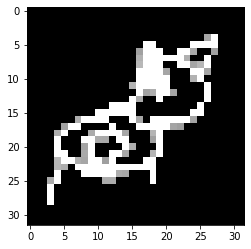

tensor(0.9819, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(0.9835, device='cuda:0', grad_fn=<SelectBackward>)
7


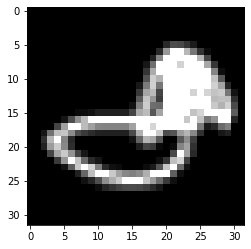

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


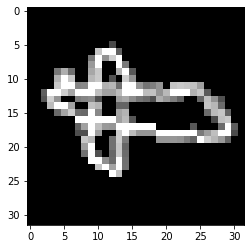

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6


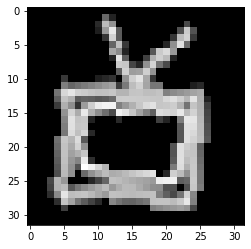

tensor(0.6182, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.6435, device='cuda:0', grad_fn=<SelectBackward>)
0


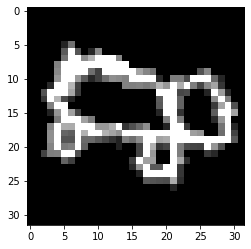

tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
4


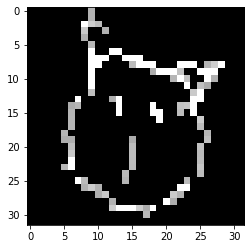

tensor(0.9525, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9566, device='cuda:0', grad_fn=<SelectBackward>)
9


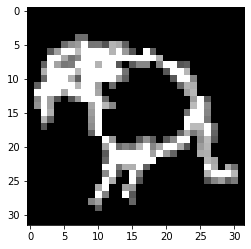

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9998, device='cuda:0', grad_fn=<SelectBackward>)
8


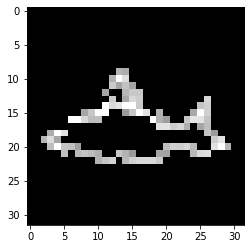

tensor(0.9975, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(0.9974, device='cuda:0', grad_fn=<SelectBackward>)
1


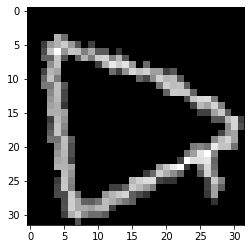

tensor(0.7860, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.8271, device='cuda:0', grad_fn=<SelectBackward>)
5


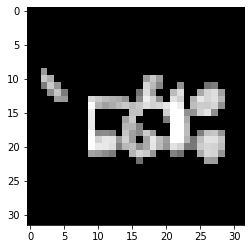

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


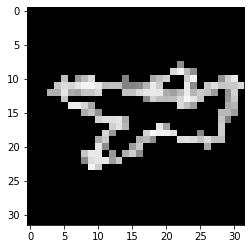

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
7
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
7


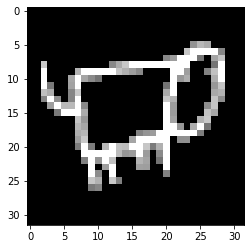

tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2


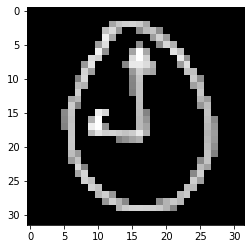

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


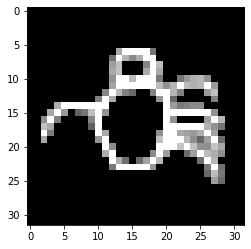

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
4


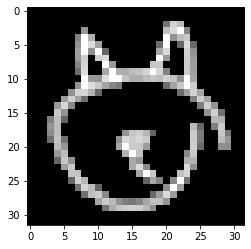

tensor(0.6082, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.5883, device='cuda:0', grad_fn=<SelectBackward>)
0


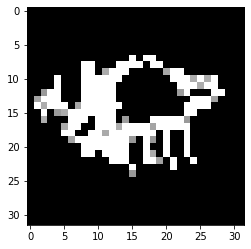

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
9


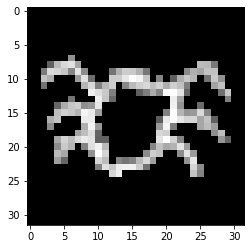

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


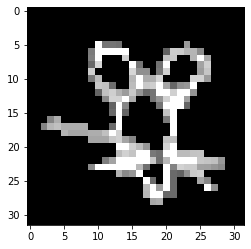

tensor(0.9995, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.9994, device='cuda:0', grad_fn=<SelectBackward>)
5


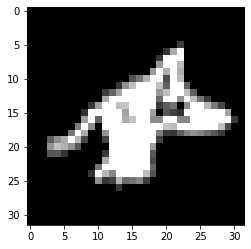

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


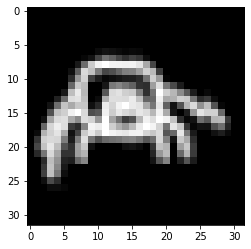

tensor(0.7832, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(0.7834, device='cuda:0', grad_fn=<SelectBackward>)
5


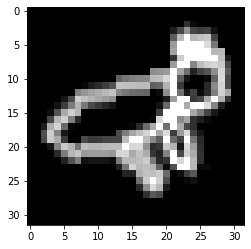

tensor(1., device='cuda:0', grad_fn=<SelectBackward>)
2
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
2


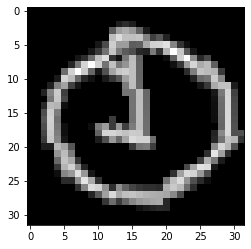

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
9


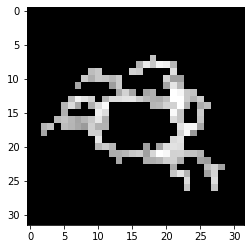

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


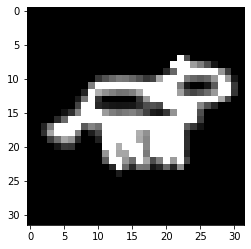

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
5


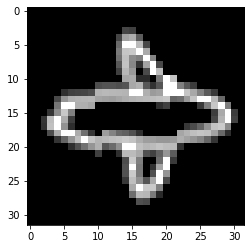

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
3


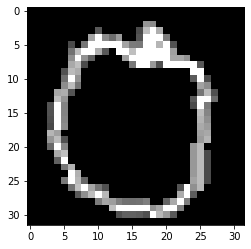

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


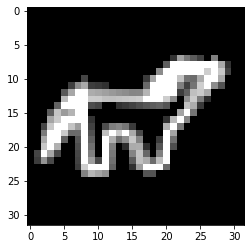

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
8


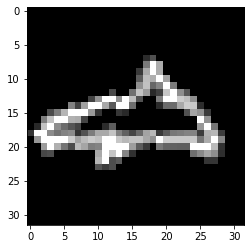

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


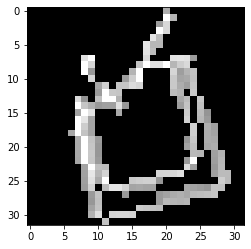

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


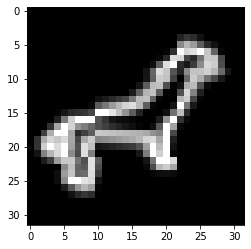

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
1


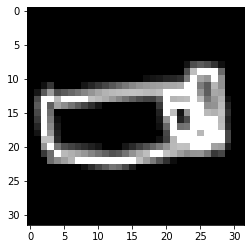

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
0


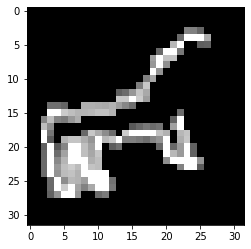

tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward>)
6
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
6


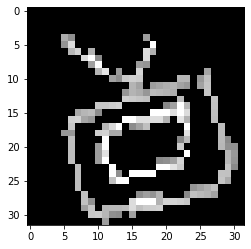

tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0
tensor(0.9999, device='cuda:0', grad_fn=<SelectBackward>)
0


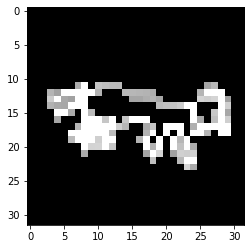

In [34]:
softmax = nn.Softmax(dim=1)

model_c0.eval()
model_c1.eval()
model_f.eval()
results = []

for i in range(3):
    result0 = []
    result1 = []
    for i, (test_data, _) in enumerate(test_dataloader):
        test_data = test_data.cuda()

        class_logits0 = model_c0(model_f(test_data))
        y0 = torch.argmax(class_logits0, dim=1).cpu().detach().numpy()
        result0.append(y0)

        class_logits1 = model_c1(model_f(test_data))
        y1 = torch.argmax(class_logits1, dim=1).cpu().detach().numpy()
        result1.append(y1)

        # show info
        probs_c1 = softmax(class_logits1)
        probs_c1, labels_c1 = torch.max(probs_c1, 1)
        print(probs_c1[0])
        print(y1[0])

        probs_c0 = softmax(class_logits0)
        probs_c0, labels_c0 = torch.max(probs_c0, 1)
        print(probs_c0[0])
        print(y0[0])

        img = tensor_to_PIL(test_data[0]).convert('RGB')
        plt.imshow(np.asarray(img))
        plt.show()

    result0 = np.concatenate(result0)
    result1 = np.concatenate(result1)
    results.append(result0)
    results.append(result1)

ans = []
for i in range(len(results[0])):
    votes = {}
    for result in results:
        vote = result[i]
        if vote not in votes:
            votes[vote] = 0

        votes[vote] += 1

    ans.append(max(votes, key=lambda x: votes[x]))

# Generate your submission
import pandas as pd
df = pd.DataFrame({'id': np.arange(0,len(ans)), 'label': ans})
df.to_csv('DaNN_submission.csv',index=False)

In [35]:
counts = [0] * 10
for label in ans:
    counts[label] += 1

print(counts)

[10908, 11355, 8891, 11395, 7319, 11088, 9932, 7023, 11653, 10436]


# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there are any problem related to Domain Adaptation, please email to b05902127@ntu.edu.tw / ntu-ml-2020spring-ta@googlegroups.com。

The Q&A section might be updated to here if I have time.
